purpose: query the EFO for parent and children terms to use for defining parallel traits in gwas catalog
based on code from obonet's tutorial:
    https://github.com/dhimmel/obonet/blob/main/examples/go-obonet.ipynb

# set-up

In [1]:
import os
import pandas as pd
import obonet as obo
import networkx as nx
import ndex2
import numpy as np
import matplotlib.pyplot as plt
from upsetplot import plot as upplot
from upsetplot import from_contents
from upsetplot import UpSet
import scipy.stats as stats
from adjustText import adjust_text
import matplotlib.patches as mpatches
import sys

In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *
from plotting_functions import *

In [3]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [4]:
save_fig=True

In [5]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# functions

In [6]:
from statsmodels.stats import contingency_tables

def calculate_enrichment(t, coloc_dict_cat, k, sub='net', total='graph', verbose=True):
    # modified from rare_common_alcohol
    # Calculate enrichment for a group of genes (sub) versus all in larger group (total)
    # Calculate values for the contingency table
    M = len(coloc_dict_cat[total])  # Population size: genes in PCNet annotated in the GWAS catalog
    n = len(coloc_dict_cat[total].intersection(t))  # Genes in PCNet annotated for the trait of interest
    N = len(coloc_dict_cat[sub])  # Genes in the network annotated in the GWAS catalog
    x = len(coloc_dict_cat[sub].intersection(t))  # Genes in network annotated for the trait of interest

    # Build contingency table
    contingency_table = [
        [x, N - x],
        [n - x, M - N - (n - x)]
    ]
    
    # Perform Fisher's exact test
    odds_ratio, p_intersect = stats.fisher_exact(contingency_table, alternative='greater')
    gene_list = t.intersection(coloc_dict_cat[sub])
    CT = contingency_tables.Table2x2(contingency_table)

    OR_p_temp = CT.oddsratio_pvalue()
    OR_CI_temp = CT.oddsratio_confint()
    OR = CT.oddsratio

    try:
        se = np.sqrt(1/x + 1/(N-x) + 1/(n-x) + 1/(M - N - (n - x)))
    except ZeroDivisionError:
        se = None
    
    # Create the results dictionary
    if verbose:
        print(f"Enrichment of network nodes in genes in the GWAS catalog annotated for {k}: p={p_intersect}")
        p_value_hypergeom = stats.hypergeom.sf(x-1, M, n, N)
        print(f'Enrichment calculated using hypergeom.sf for {k}: p={p_value_hypergeom}, p_contingency_table={OR_p_temp}')
        print(f"Odds ratio: OD={odds_ratio}, via_contingency OR={OR}")
        print(f"Number of annotated genes in {total}: {len(t.intersection(coloc_dict_cat[total]))}")
        print(f"Number of annotated genes in {sub}: {len(t.intersection(coloc_dict_cat[sub]))}\n")
        print(f"Number of genes in interactome annotated for trait: {N}")
    return odds_ratio, se, p_intersect, gene_list


# import network genelists

## Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [7]:
interactome_name='PCNet2.0'

In [8]:
graph=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)
all_nodes=list(graph.nodes())

PCNet2.0
Name: PCNet 2.0
Nodes: 19267
Edges: 3852119
Node Attributes: 19267
Edge Attributes: 19260595

number of nodes:
19267

number of edges:
3852119


## import NPS scores and seed genes

In [9]:
seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,all_nodes)
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR', 'loco_final_cf_bonf', 'loco_final_cf_top500', 'loco_final_cf_FDR', 'loco_final_mega_bonf', 'loco_final_mega_top500', 'loco_final_mega_FDR'])

In [10]:
#dictionary of human control traits
ctrl_dict={}
ctrl_traits=['facial_hair', 'age_smkinit', 'antisoc', 'friend_sat', 'hr', 'infant_bw', 'LDL', 'maternal_smok', 'townsend', 'age_menarche', 'neurot','addict-rf']
for t in ctrl_traits:
    ctrl_dict[t]=pd.read_csv('gwas_ctrl_hm/magma/seed_genes/'+t+'_annot.tsv',sep='\t')
for t in ctrl_traits:
    seed_dict[t+'_FDR']=(set(ctrl_dict[t][ctrl_dict[t]['Q']<0.05]['GENE']))
    seed_dict[t+'_bonf']=(set(ctrl_dict[t][ctrl_dict[t]['P']<0.05/len(ctrl_dict[t])]['GENE']))
    seed_dict[t+'_top500']=set(ctrl_dict[t][(ctrl_dict[t]['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])

In [11]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,UUIDs)
NPS_dict.keys()

dict_keys(['loco_bonf_PCNet2.0', 'loco_bonf_PCNet2.1', 'loco_bonf_PCNet2.2', 'loco_FDR_PCNet2.0', 'loco_FDR_PCNet2.1', 'loco_FDR_PCNet2.2', 'loco_gsem_bonf_PCNet2.0', 'loco_gsem_bonf_PCNet2.1', 'loco_gsem_bonf_PCNet2.2', 'loco_gsem_FDR_PCNet2.0', 'loco_gsem_FDR_PCNet2.1', 'loco_gsem_FDR_PCNet2.2', 'ext_bonf_PCNet2.0', 'ext_bonf_PCNet2.1', 'ext_bonf_PCNet2.2', 'ext_top500_PCNet2.0', 'ext_top500_PCNet2.1', 'ext_top500_PCNet2.2', 'ext_FDR_PCNet2.0', 'ext_FDR_PCNet2.1', 'ext_FDR_PCNet2.2', 'ext_st22_PCNet2.0', 'ext_st22_PCNet2.1', 'ext_st22_PCNet2.2', 'loco_mega_fus_naac_bonf_PCNet2.0', 'loco_mega_fus_naac_bonf_PCNet2.1', 'loco_mega_fus_naac_bonf_PCNet2.2', 'loco_mega_fus_naac_FDR_PCNet2.0', 'loco_mega_fus_naac_FDR_PCNet2.1', 'loco_mega_fus_naac_FDR_PCNet2.2', 'ext_fus_naac_bonf_PCNet2.0', 'ext_fus_naac_bonf_PCNet2.1', 'ext_fus_naac_bonf_PCNet2.2', 'ext_fus_naac_top500_PCNet2.0', 'ext_fus_naac_top500_PCNet2.1', 'ext_fus_naac_top500_PCNet2.2', 'ext_fus_naac_FDR_PCNet2.0', 'ext_fus_naac_FDR_

# import the network of EFO terms

In [12]:
#graphical representation of the EFO ontology database
graph = obo.read_obo('https://www.ebi.ac.uk/efo/efo.obo')

In [13]:
#get id from name or name from ID
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [14]:
nodes=list(graph.nodes())

In [15]:
# check for non-specific network names
[x for x in nodes if ('_' in x)]
#some nodes contain "_" and some contain ":"- WHY- only the 2 BAO entries, an inexplicable URL, and NCBITaxon_Union- just replace BAO
#BAO_x are Cycline-6-phospah
# ['BAO_0000875']:'Cyclic adenosine monophosphate'
# ['BAO_0000925']:'Glucose-6-phosphate'
# NCBITaxon_Union_0000023 has no definition online.

#not going to replace substring- but here's the code for that

#nodesf=set([(lambda x: x.replace('_',':'))(x) for x in nodes])
#len(set(nodes))-len(nodesf)
#length is equal so not redundant

['BAO_0000875',
 'BAO_0000925',
 'http://dbpedia.org/resource/Republic_of_Ireland']

In [16]:
[x for x in nodes if ('BAO' in x)]

['BAO_0000875', 'BAO_0000925']

In [17]:
[id_to_name[x] for x in nodes if ('NCIT' in x)]

['S-Adenosylhomocysteine',
 'decreased attention',
 'Tilarginine',
 'Country',
 'Guanosine Diphosphate',
 'nervousness',
 'Gentisic Acid',
 'Alpha-Ketoglutaric Acid',
 'Hippuric Acid',
 'sleepiness']

In [18]:
nx.is_directed_acyclic_graph(graph) #undirected network??? HOW???

False

# import EFO table from GWAS catalog

In [19]:
#ontology mapping table for GWAS catalog
onto=pd.read_csv('validation_datasets/trait_mappings.txt',sep='\t')

In [20]:
onto['EFO_term']=onto['EFO URI'].apply(lambda x: x.split('/')[len(x.split('/'))-1])
onto['EFO_term']=onto['EFO_term'].str.replace('_',':')

In [21]:
onto['EFO_parent']=onto['Parent URI'].apply(lambda x: x.split('/')[len(x.split('/'))-1])
onto['EFO_parent']=onto['EFO_parent'].str.replace('_',':')

In [22]:
onto['Disease trait']=onto['Disease trait'].str.lower()
o=set(onto['Disease trait'])
e=(set(onto['EFO_term']))

In [23]:
onto['EFO_parent_idtoname']=onto['EFO_parent'].map(id_to_name)

In [24]:
onto[['Parent term','EFO_parent_idtoname','EFO_parent']].drop_duplicates()

Parent term                 EFO_parent_idtoname  \
0                                Cancer                            neoplasm   
4                           Other trait                 experimental factor   
8                Immune system disorder               immune system disease   
11                        Other disease                             disease   
46               Cardiovascular disease              cardiovascular disease   
49                Neurological disorder              nervous system disease   
71                    Other measurement                         measurement   
364                  Biological process                  biological_process   
537    Lipid or lipoprotein measurement             lipoprotein measurement   
790                    Body measurement           body weights and measures   
1046         Cardiovascular measurement          cardiovascular measurement   
1390                 Metabolic disorder                   metabolic disease   
1512   Lipid or lipoprotein measurement                   lipid measurement   
4609           Inflammatory measurement  inflammatory biomarker measurement   
5637                                 NR                                 NaN   
5727          Digestive system disorder            digestive system disease   
7288          Hematological measurement           hematological measurement   
37375          Liver enzyme measurement                                 NaN   

        EFO_parent  
0      EFO:0000616  
4      EFO:0000001  
8      EFO:0000540  
11     EFO:0000408  
46     EFO:0000319  
49     EFO:0000618  
71     EFO:0001444  
364     GO:0008150  
537    EFO:0004732  
790    EFO:0004324  
1046   EFO:0004298  
1390   EFO:0000589  
1512   EFO:0004529  
4609   EFO:0004872  
5637            NR  
5727   EFO:0000405  
7288   EFO:0004503  
37375  EFO:0004582

## import gwas catalog associations

In [25]:
gwas_catalog=pd.read_csv('validation_datasets/gwas-catalog_v1.0.2_20240807.tsv',sep='\t',low_memory=False)
cat=format_catalog(gwas_catalog)

In [26]:
cat=cat.merge(onto, left_on='DISEASE/TRAIT',right_on='Disease trait')

# redefine parent terms in GWAS catalog ontology table

parent terms in the GWAS catalog are at random depths within the catalog, which is confusing for the enrichment analysis. To fix this, I'm going to redefine them in the following terms:

disease
measurement
biological function
experimental factor (if not present in the above 3)
NR- not in EFO

this way, most of the parents will be in one of the above terms, THEN, we can look at children in a more informative way

In [27]:
sorted(set(onto['EFO_parent_idtoname'].dropna()))

['biological_process',
 'body weights and measures',
 'cardiovascular disease',
 'cardiovascular measurement',
 'digestive system disease',
 'disease',
 'experimental factor',
 'hematological measurement',
 'immune system disease',
 'inflammatory biomarker measurement',
 'lipid measurement',
 'lipoprotein measurement',
 'measurement',
 'metabolic disease',
 'neoplasm',
 'nervous system disease']

## identify shared parent terms

In [28]:
parents=set(cat['EFO_parent'])
parents.discard('NR')
for k in sorted(parents):
    print(id_to_name[k])
    if k in nodes:
        #return_efo_ancestors_name(graph,id_to_name,k)
        #print(': \n')
        print((list((id_to_name[supterm] for supterm in nx.descendants(graph, k))))) #descendents get superterms- not sure why)
        print('\n')
    else:
        print(' not in EFO. \n')

experimental factor
[]


cardiovascular disease
['organism part', 'cardiovascular system', 'Eukaryota', 'multicellular organism', None, 'anatomical structure', 'anatomical system', 'Homo sapiens', 'disease', 'organism', 'material entity', None, 'experimental factor', None, 'anatomy basic component', 'material property', 'disposition', 'anatomical entity', None, 'circulatory system', None]


digestive system disease
['anatomical system', 'material property', 'Homo sapiens', 'disposition', 'digestive system', 'disease', 'anatomy basic component', 'organism', None, 'anatomical entity', 'material entity', 'organism part', 'Eukaryota', 'alimentary part of gastrointestinal system', 'multicellular organism', 'experimental factor', 'anatomical structure']


disease
['material property', 'disposition', 'experimental factor']


immune system disease
['material property', 'Homo sapiens', 'disposition', 'immune system', 'disease', 'anatomical entity', 'organism part', 'organism', 'material entity'

KeyError: 'EFO:0004582'

## define new parent catagories

In [29]:
par=['disease','measurement','biological_process','experimental factor']

In [30]:
par_children={}
for x in par:
    par_children[x]=nx.ancestors(graph,name_to_id[x])

In [31]:
par_children['experimental factor']=par_children['experimental factor']-par_children['biological_process']-par_children['measurement']-par_children['disease']

In [32]:
par_children_terms={}
for j in par_children.keys():
    print(j)
    par_children_terms[j]=[id_to_name[k] for k in list(par_children[j])]

disease
measurement
biological_process
experimental factor


## make upset plot showing overlap of new parent traits

In [33]:
par_children_cat={}
for x in par:
    par_children_cat[x]=par_children[x].intersection(set(onto.EFO_term))

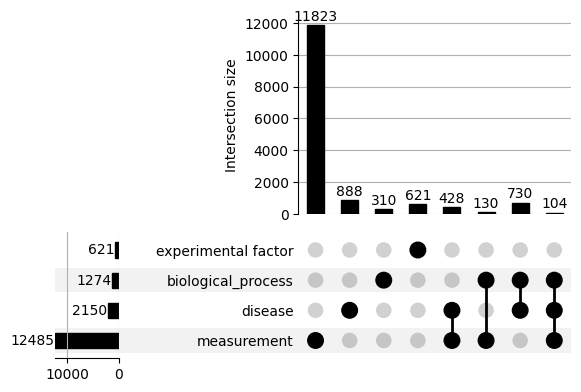

In [34]:
#check overlap for only traits in the GWAS catalog
table=from_contents(par_children_cat)  
UpSet(table, subset_size='count',show_counts=True).plot()
if save_fig:
    plt.savefig('figures/' + 'gwas_catalog_parent_upset.pdf')

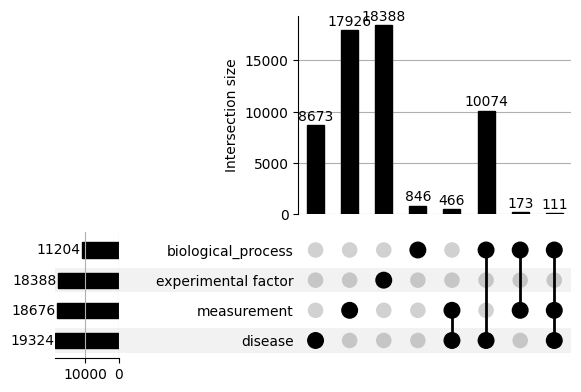

In [35]:
#check for all traits
table=from_contents(par_children)  
UpSet(table, subset_size='count',show_counts=True).plot()
if save_fig:
    plt.savefig('figures/' + 'gwas_catalog_parent_upset.pdf')

## calculate number of genes per trait

In [36]:
gpt_path='validation_datasets/GWAS-CAT-EFO_genes_per_trait.csv'
if (os.path.isfile(gpt_path)):
    genes_per_trait=pd.read_csv(gpt_path)
    print('reading in file')
else:
    print('calculating genes per trait')
    genes_per_trait=count_genes_per_trait([name_to_id[x] for x in par],cat,'GENE','EFO_term',id_to_name,name_to_id,graph)
    genes_per_trait.to_csv(gpt_path,index=False)

reading in file


# choose datasets for analysis- put gene lists into dictionary

In [37]:
#modify for correct genesets
cut_r= 'FDR'
cut_h='top500'
trait_r='loco_final_cf'
trait_h='ext'

#choose which community to check enrichment for
#must be keys from coloc_dict
sub_community='net'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)

In [38]:
filter_traits=False
gpt=genes_per_trait[(genes_per_trait.ngenes>=5)]

In [39]:
#get rest of datasets based on what was specified above
coloc_dict=def_coloc_dict(seed_r,seed_h,NPS,all_nodes,cut_single,cut_comb,cut_rat_specific,cut_hm_specific)
val_lab_dict=def_val_label_dict(label_h,label_r,interactome_name,cut_single,cut_comb)

In [63]:
#sub_community is the community being tested for enrichment (i.e. the ext-loco network, 'net')
#whole_community is the greater pool of genes to test against (i.e. PCNET ('graph'))
if sub_community in val_lab_dict.keys():
    whole_community=coloc_dict_ref[sub_community]
    outpath=f'validation_output/GWAS-CAT-EFO_enr_{val_lab_dict[sub_community]}_enr.csv'

else:
    print('sub_community not in val_lab_dict- using graph as the whole_community')
    whole_community='graph'
    outpath='validation_output/GWAS-CAT-EFO_enr_temp.csv'
print(f'path for this output file: {outpath}')
if (outpath=='validation_output/GWAS-CAT-EFO_enr_temp.csv'):
    print('sub_community not in dictionary- will be saved as a temporary file (may overwrite previous temporary file).')
elif (os.path.isfile(outpath)):
    run_analysis=False
    print('this analysis has been run previously- importing from file. If want to rerun, set run_analysis to True')
    tbl=pd.read_csv(outpath)
else:
    run_analysis=True
    print('this analysis has not been run- run_analysis set to True')

path for this output file: validation_output/GWAS-CAT-EFO_enr_network-ext_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_enr.csv
this analysis has been run previously- importing from file. If want to rerun, set run_analysis to True


# validate whole geneset at all depths of the GWAS catalog

In [48]:
if run_analysis:
    coloc_dict_cat={}
    for k in coloc_dict.keys():
        coloc_dict_cat[k]=set(coloc_dict[k]).intersection(list(cat['GENE'].dropna()))

In [49]:
print(f'WARNING: YOU ARE CURRENTLY ANALYZING THE ENRICHMENT OF {sub_community} RELATIVE TO {whole_community}.\n\tTHIS IS CALCULATED FROM {label_r}, {label_h}, AND {interactome_name}.\n\tIF THIS IS CORRECT, CONTINUE :)')

	THIS IS CALCULATED FROM loco_final_cf_FDR, ext_top500, AND PCNet2.0.
	IF THIS IS CORRECT, CONTINUE :)


In [ ]:
if run_analysis:
    tbl=recurse_enrichment(par,graph,id_to_name, 
        name_to_id,'exploratory factor',cat,'EFO_term','GENE',
        coloc_dict_cat,sub_community,
        whole_community,outpath,depth=0,depth_term=5,verbose=False,enr_concat=None)
    #tbl.to_csv(outpath,index=False)
    #print(f'table saved as {outpath}')

analyzing structure depth=0
Enrichment of network nodes in genes in the GWAS catalog annotated for disease: p=0.0027743236937155173
Enrichment calculated using hypergeom.sf for disease: p=0.0027743236937155173
Odds ratio: OD=2.021553852429102
Number of annotated genes in graph: 15766
Number of annotated genes in net: 239

Enrichment of network nodes in genes in the GWAS catalog annotated for measurement: p=0.23624104982750593
Enrichment calculated using hypergeom.sf for measurement: p=0.23624104982750593
Odds ratio: OD=1.3522106905033295
Number of annotated genes in graph: 16914
Number of annotated genes in net: 245

Enrichment of network nodes in genes in the GWAS catalog annotated for biological_process: p=0.0001790802631282216
Enrichment calculated using hypergeom.sf for biological_process: p=0.0001790802631282216
Odds ratio: OD=1.9553389673678367
Number of annotated genes in graph: 14200
Number of annotated genes in net: 225

Enrichment of network nodes in genes in the GWAS catalog

In [50]:
tbl

trait              parent_trait  \
0                        experimental factor        exploratory factor   
1                         biological_process        exploratory factor   
2                                measurement        exploratory factor   
3                                    disease        exploratory factor   
4                       temporal measurement               measurement   
...                                      ...                       ...   
57974015                        hip fracture             bone fracture   
57974016                      polyp of colon  polyp of large intestine   
57974017             diglyceride measurement               diglyceride   
57974018                diabetic maculopathy      diabetic retinopathy   
57974019  proliferative diabetic retinopathy      diabetic retinopathy   

                                            community_genes  \
0         {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...   
1         {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...   
2         {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...   
3         {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...   
4         {'GNPDA2', 'DAOA', 'KCNMB1', 'RPS6KB1', 'GRIA1...   
...                                                     ...   
57974015  {'TULP4', 'RBFOX1', 'PLAG1', 'GRM1', 'DOCK9', ...   
57974016                                           {'NID2'}   
57974017  {'GNPDA2', 'XKR5', 'GABRB3', 'PI4KA', 'NR4A1',...   
57974018                                           {'USP7'}   
57974019                        {'NRXN3', 'UTRN', 'RBFOX1'}   

          n_community_genes  odds_ratio  log_se_or   p_intersect  depth  
0                       251    0.543853   0.588408  9.147691e-01      0  
1                       225    1.955339   0.198199  1.790803e-04      0  
2                       245    1.352211   0.341263  2.362410e-01      0  
3                       239    2.021554   0.267250  2.774324e-03      0  
4                        98    2.172943   0.130165  6.654267e-09      1  
...                     ...         ...        ...           ...    ...  
57974015                 22    1.374790   0.225193  1.017029e-01      5  
57974016                  1    2.301318   1.018500  3.605620e-01      5  
57974017                 58    2.107834   0.151238  2.803017e-06      5  
57974018                  1    6.911858   1.050719  1.466466e-01      5  
57974019                  3    7.199341   0.609801  1.057395e-02      5  

[57974020 rows x 8 columns]

In [60]:
tbl=tbl.drop_duplicates()

trait        parent_trait  \
0              experimental factor  exploratory factor   
1               biological_process  exploratory factor   
2                      measurement  exploratory factor   
3                          disease  exploratory factor   
4             temporal measurement         measurement   
...                            ...                 ...   
57945891  progesterone measurement        progesterone   
57948052             AIDS dementia            dementia   
57952376        Lewy body dementia            dementia   
57956702         Alzheimer disease            dementia   
57961030       hereditary dementia            dementia   

                                            community_genes  \
0         {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...   
1         {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...   
2         {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...   
3         {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...   
4         {'GNPDA2', 'DAOA', 'KCNMB1', 'RPS6KB1', 'GRIA1...   
...                                                     ...   
57945891                                {'VIPR2', 'RBFOX1'}   
57948052                                          {'NALCN'}   
57952376                                          {'KCNB2'}   
57956702  {'DAOA', 'GRM1', 'RPS6KB1', 'GRIA1', 'KPNA7', ...   
57961030               {'STMN2', 'KCNB2', 'PJA2', 'MAP2K5'}   

          n_community_genes  odds_ratio  log_se_or   p_intersect  depth  \
0                       251    0.543853   0.588408  9.147691e-01      0   
1                       225    1.955339   0.198199  1.790803e-04      0   
2                       245    1.352211   0.341263  2.362410e-01      0   
3                       239    2.021554   0.267250  2.774324e-03      0   
4                        98    2.172943   0.130165  6.654267e-09      1   
...                     ...         ...        ...           ...    ...   
57945891                  2    6.604686   0.742728  4.235793e-02      5   
57948052                  1   69.154150   1.415631  2.841415e-02      5   
57952376                  1    1.326011   1.011554  5.346601e-01      5   
57956702                 77    2.341947   0.138092  4.929888e-09      5   
57961030                  4    2.397379   0.512521  9.369061e-02      5   

           seed_h   seed_r  n_seed_h  n_seed_r  n_seed  
0              {}       {}         0         0       0  
1              {}       {}         0         0       0  
2              {}       {}         0         0       0  
3              {}       {}         0         0       0  
4              {}       {}         0         0       0  
...           ...      ...       ...       ...     ...  
57945891       {}       {}         0         0       0  
57948052  {NALCN}  {NALCN}         1         1       2  
57952376       {}       {}         0         0       0  
57956702       {}       {}         0         0       0  
57961030       {}       {}         0         0       0  

[6726 rows x 13 columns]

In [66]:
if ('net' in sub_community):
    if not 'n_seed' in tbl.columns:
        if 'community_genes' in tbl.columns:
            col='community_genes'
        else:
            col='network_genes'
        if type(tbl[col].iloc[0])!=set:
            tbl['seed_h']=tbl[col].apply(lambda x: set(x.replace("'","").replace("{","").replace("}","").split(',')).intersection(coloc_dict['seed_h']))
            tbl['seed_r']=tbl[col].apply(lambda x: set(x.replace("'","").replace("{","").replace("}","").split(',')).intersection(coloc_dict['seed_h']))
        else:
            tbl['seed_h']=tbl[col].apply(lambda x: x.intersection(coloc_dict['seed_h']))
            tbl['seed_r']=tbl[col].apply(lambda x: x.intersection(coloc_dict['seed_r']))
        tbl['n_seed_h']=tbl.seed_h.apply(lambda x: len(x))
        tbl['n_seed_r']=tbl.seed_r.apply(lambda x: len(x))
        tbl['n_seed']=tbl['n_seed_h']+tbl['n_seed_r']
        if not filter_traits:
            tbl.to_csv(outpath,index=False)
        tbl.sort_values('n_seed',ascending=False).head()
tbl=tbl.merge(gpt,left_on='trait',right_on='trait_name').drop('trait_name',axis=1)
tbl.to_csv(outpath,index=False)

In [69]:
tbl

trait        parent_trait  \
0                      experimental factor  exploratory factor   
1                       biological_process  exploratory factor   
2                       biological_process             process   
3                              measurement  exploratory factor   
4                              measurement  information entity   
...                                    ...                 ...   
6567                              wheezing     sign or symptom   
6568                                sterol             steroid   
6569        dehydroepiandrosterone sulfate             steroid   
6570                     cholesteryl ester             steroid   
6571  high-density lipoprotein cholesterol             steroid   

                                        community_genes  n_community_genes  \
0     {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...                251   
1     {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...                225   
2     {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...                225   
3     {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...                245   
4     {'GNPDA2', 'DAOA', 'GABRB3', 'KCNMB1', 'SHTN1'...                245   
...                                                 ...                ...   
6567                                          {'NLGN1'}                  1   
6568  {'GNPDA2', 'DAOA', 'GABRB3', 'PAX4', 'RPS6KB1'...                 86   
6569                                         {'CAMTA1'}                  1   
6570                                {'GPR180', 'DHX38'}                  2   
6571  {'TRAIP', 'PIAS4', 'DAOA', 'XKR5', 'MDGA2', 'C...                 63   

      odds_ratio  log_se_or  p_intersect  depth      seed_h      seed_r  \
0       0.543853   0.588408     0.914769      0       set()       set()   
1       1.955339   0.198199     0.000179      0       set()       set()   
2       1.955339   0.198199     0.000179      2       set()       set()   
3       1.352211   0.341263     0.236241      0       set()       set()   
4       1.352211   0.341263     0.236241      2       set()       set()   
...          ...        ...          ...    ...         ...         ...   
6567    2.030109   1.016573     0.396447      5       set()       set()   
6568    1.512688   0.133727     0.001524      5       set()       set()   
6569    1.111501   1.010019     0.597308      5  {'CAMTA1'}  {'CAMTA1'}   
6570    0.620412   0.713128     0.831480      5       set()       set()   
6571    1.669209   0.146709     0.000516      5   {'TRAIP'}   {'TRAIP'}   

      n_seed_h  n_seed_r  n_seed  ngenes     trait_ID  
0            0         0       0   42297  EFO:0000001  
1            0         0       0   27374   GO:0008150  
2            0         0       0   27374   GO:0008150  
3            0         0       0   37981  EFO:0001444  
4            0         0       0   37981  EFO:0001444  
...        ...       ...     ...     ...          ...  
6567         0         0       0      65  EFO:0009715  
6568         0         0       0    7162  CHEBI:15889  
6569         1         1       2     103  CHEBI:16814  
6570         0         0       0     308  CHEBI:17002  
6571         1         1       2    4622  CHEBI:47775  

[6572 rows x 15 columns]

In [50]:
#filter_traits=True
print(f'filter traits={filter_traits}')

filter traits=False


In [70]:
if filter_traits:
    print('filtering traits')
    tbl=tbl[tbl.trait.isin(gpt.trait_name)]
tbl[tbl.p_intersect<0.05/len(tbl)].sort_values('n_seed')

trait                       parent_trait  \
7                temporal measurement                        measurement   
4421           pyridoxate measurement  carboxylic acid anion measurement   
4422         salicylurate measurement  carboxylic acid anion measurement   
4423         salicylurate measurement  carboxylic acid anion measurement   
4426             substance dependence         substance-related disorder   
...                               ...                                ...   
2687       substance-related disorder               psychiatric disorder   
2686       substance-related disorder               psychiatric disorder   
2199      Neurodevelopmental disorder             nervous system disease   
2160  hereditary neurological disease                   genetic disorder   
4168         electrically active cell                          cell type   

                                        community_genes  n_community_genes  \
7     {'GNPDA2', 'DAOA', 'KCNMB1', 'RPS6KB1', 'GRIA1...                 98   
4421  {'GNPDA2', 'XKR5', 'GABRB3', 'PI4KA', 'NR4A1',...                 59   
4422  {'GNPDA2', 'XKR5', 'GABRB3', 'PI4KA', 'NR4A1',...                 58   
4423  {'GNPDA2', 'XKR5', 'GABRB3', 'PI4KA', 'NR4A1',...                 58   
4426  {'GABRB3', 'C4orf17', 'SHTN1', 'CHRNA3', 'RBFO...                 32   
...                                                 ...                ...   
2687  {'TRAIP', 'MDGA2', 'UTRN', 'TULP4', 'GABRB3', ...                 58   
2686  {'TRAIP', 'MDGA2', 'UTRN', 'TULP4', 'GABRB3', ...                 58   
2199  {'TRAIP', 'PAX4', 'CAMKV', 'GAD1', 'CHRNA3', '...                 42   
2160  {'MDGA2', 'GABRA2', 'NPTN', 'NR4A1', 'CACNA1B'...                 48   
4168  {'MDGA2', 'UTRN', 'TULP4', 'NPTN', 'RBFOX1', '...                 41   

      odds_ratio  log_se_or   p_intersect  depth     seed_h     seed_r  \
7       2.172943   0.130165  6.654267e-09      1      set()      set()   
4421    2.177044   0.150369  9.812881e-07      5      set()      set()   
4422    2.144083   0.151260  1.761788e-06      3      set()      set()   
4423    2.144083   0.151260  1.761788e-06      5      set()      set()   
4426    3.241212   0.192760  7.624298e-08      3      set()      set()   
...          ...        ...           ...    ...        ...        ...   
2687    3.906747   0.152370  2.643175e-15      5  {'TRAIP'}  {'TRAIP'}   
2686    3.906747   0.152370  2.643175e-15      2  {'TRAIP'}  {'TRAIP'}   
2199    2.555173   0.171413  5.384491e-07      2  {'TRAIP'}  {'TRAIP'}   
2160    2.355543   0.162436  9.400969e-07      5  {'MDGA2'}  {'MDGA2'}   
4168    2.713437   0.173231  1.693198e-07      3  {'MDGA2'}  {'MDGA2'}   

      n_seed_h  n_seed_r  n_seed  ngenes       trait_ID  
7            0         0       0    6974    EFO:0000719  
4421         0         0       0    3468    EFO:0010527  
4422         0         0       0    3452    EFO:0010532  
4423         0         0       0    3452    EFO:0010532  
4426         0         0       0    1329  MONDO:0004938  
...        ...       ...     ...     ...            ...  
2687         1         1       2    2277  MONDO:0002494  
2686         1         1       2    2277  MONDO:0002494  
2199         1         1       2    2175    EFO:0010642  
2160         1         1       2    2630  MONDO:0100545  
4168         1         1       2    2131     CL:0000211  

[1018 rows x 15 columns]

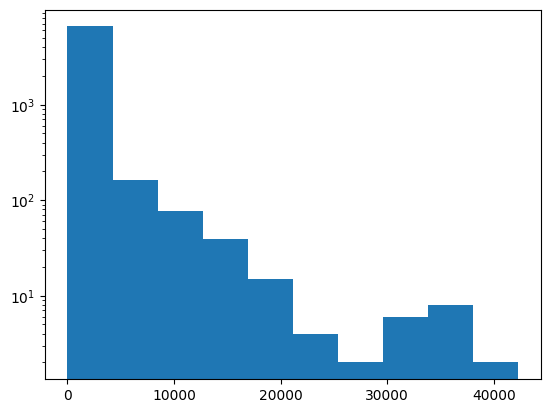

In [57]:
plt.hist(gpt.ngenes)
plt.yscale('log')

# plot enrichment

In [100]:
save_fig=True

In [71]:
if save_fig==True:
    outpath_dir=outpath[:len(outpath)-4]
    if not os.path.exists(outpath_dir):
        os.makedirs(outpath_dir)

In [72]:
colormap=plt.colormaps.get_cmap('tab20b')

6887

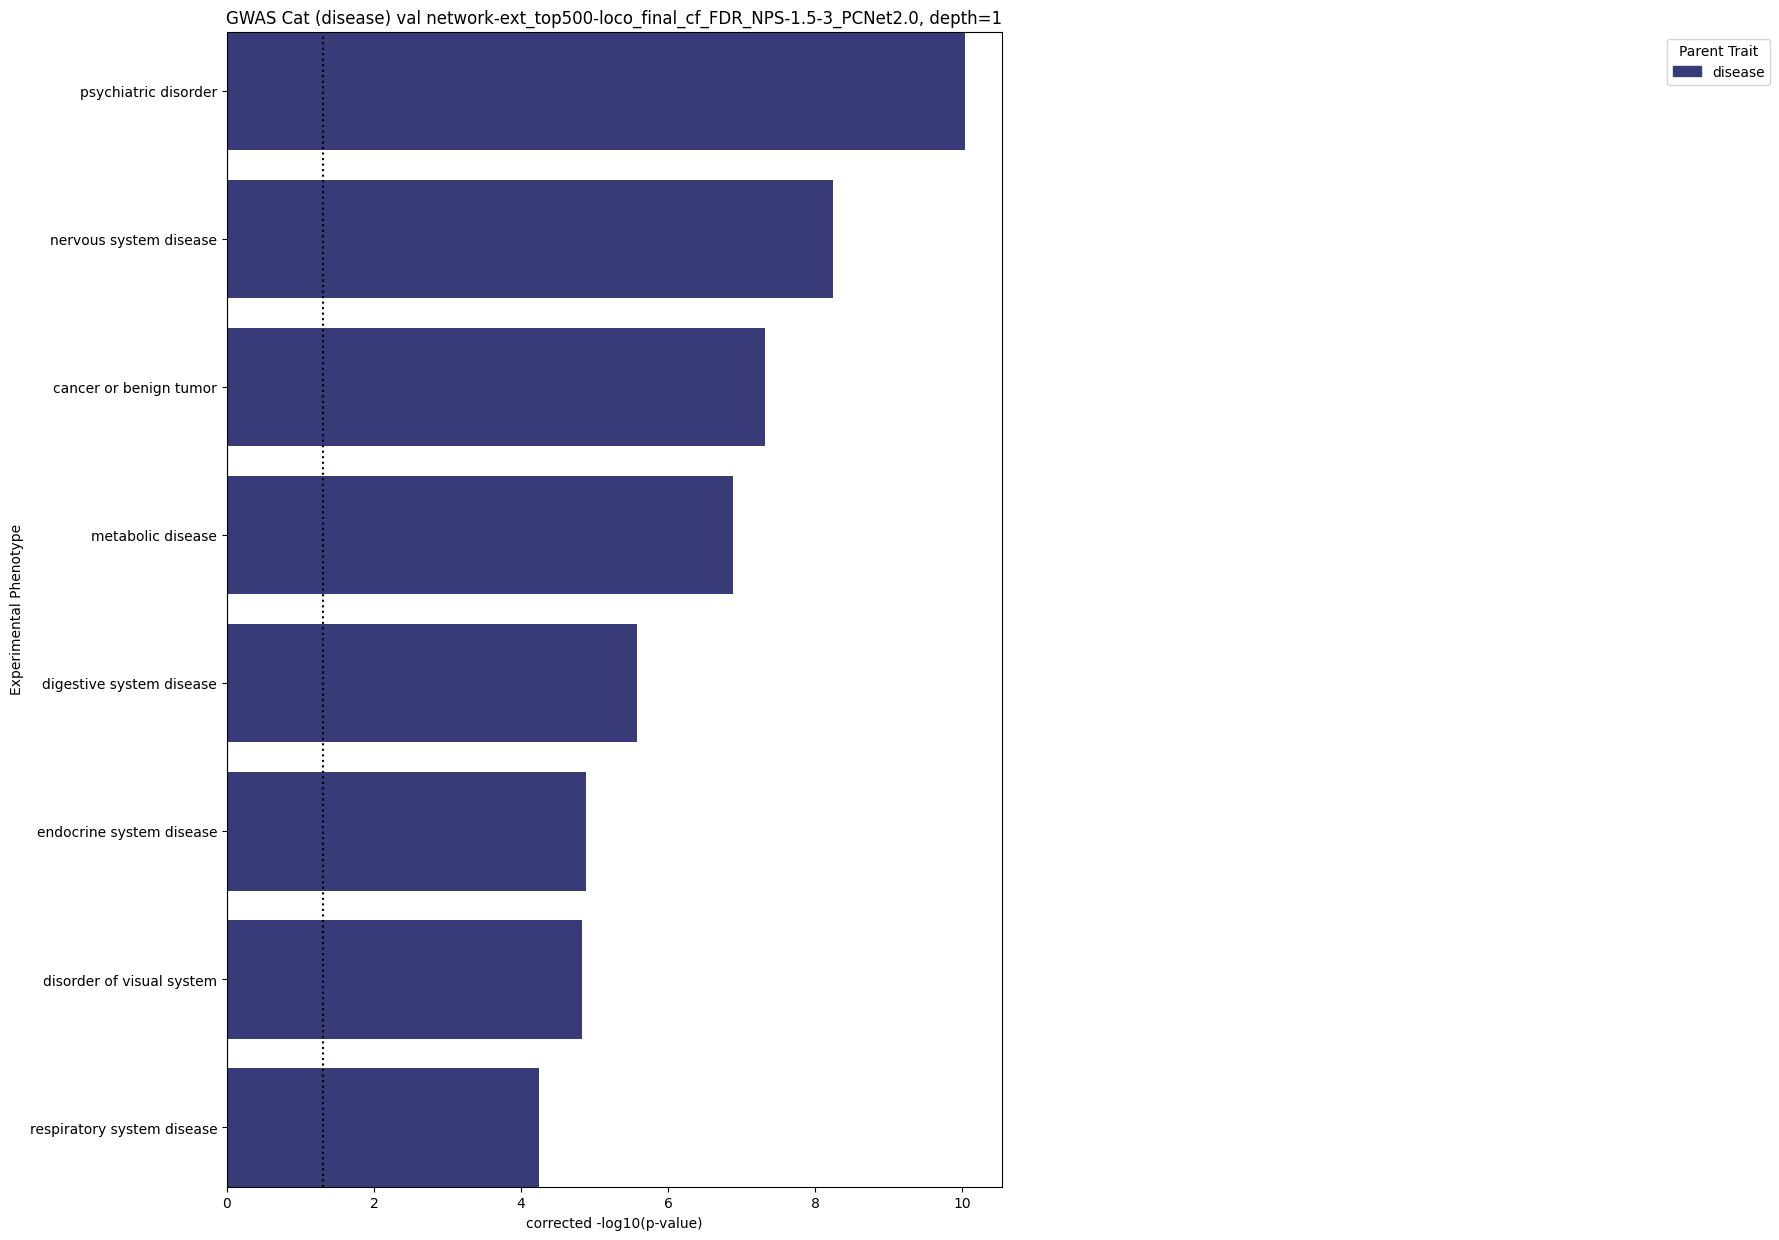

<Figure size 640x480 with 0 Axes>

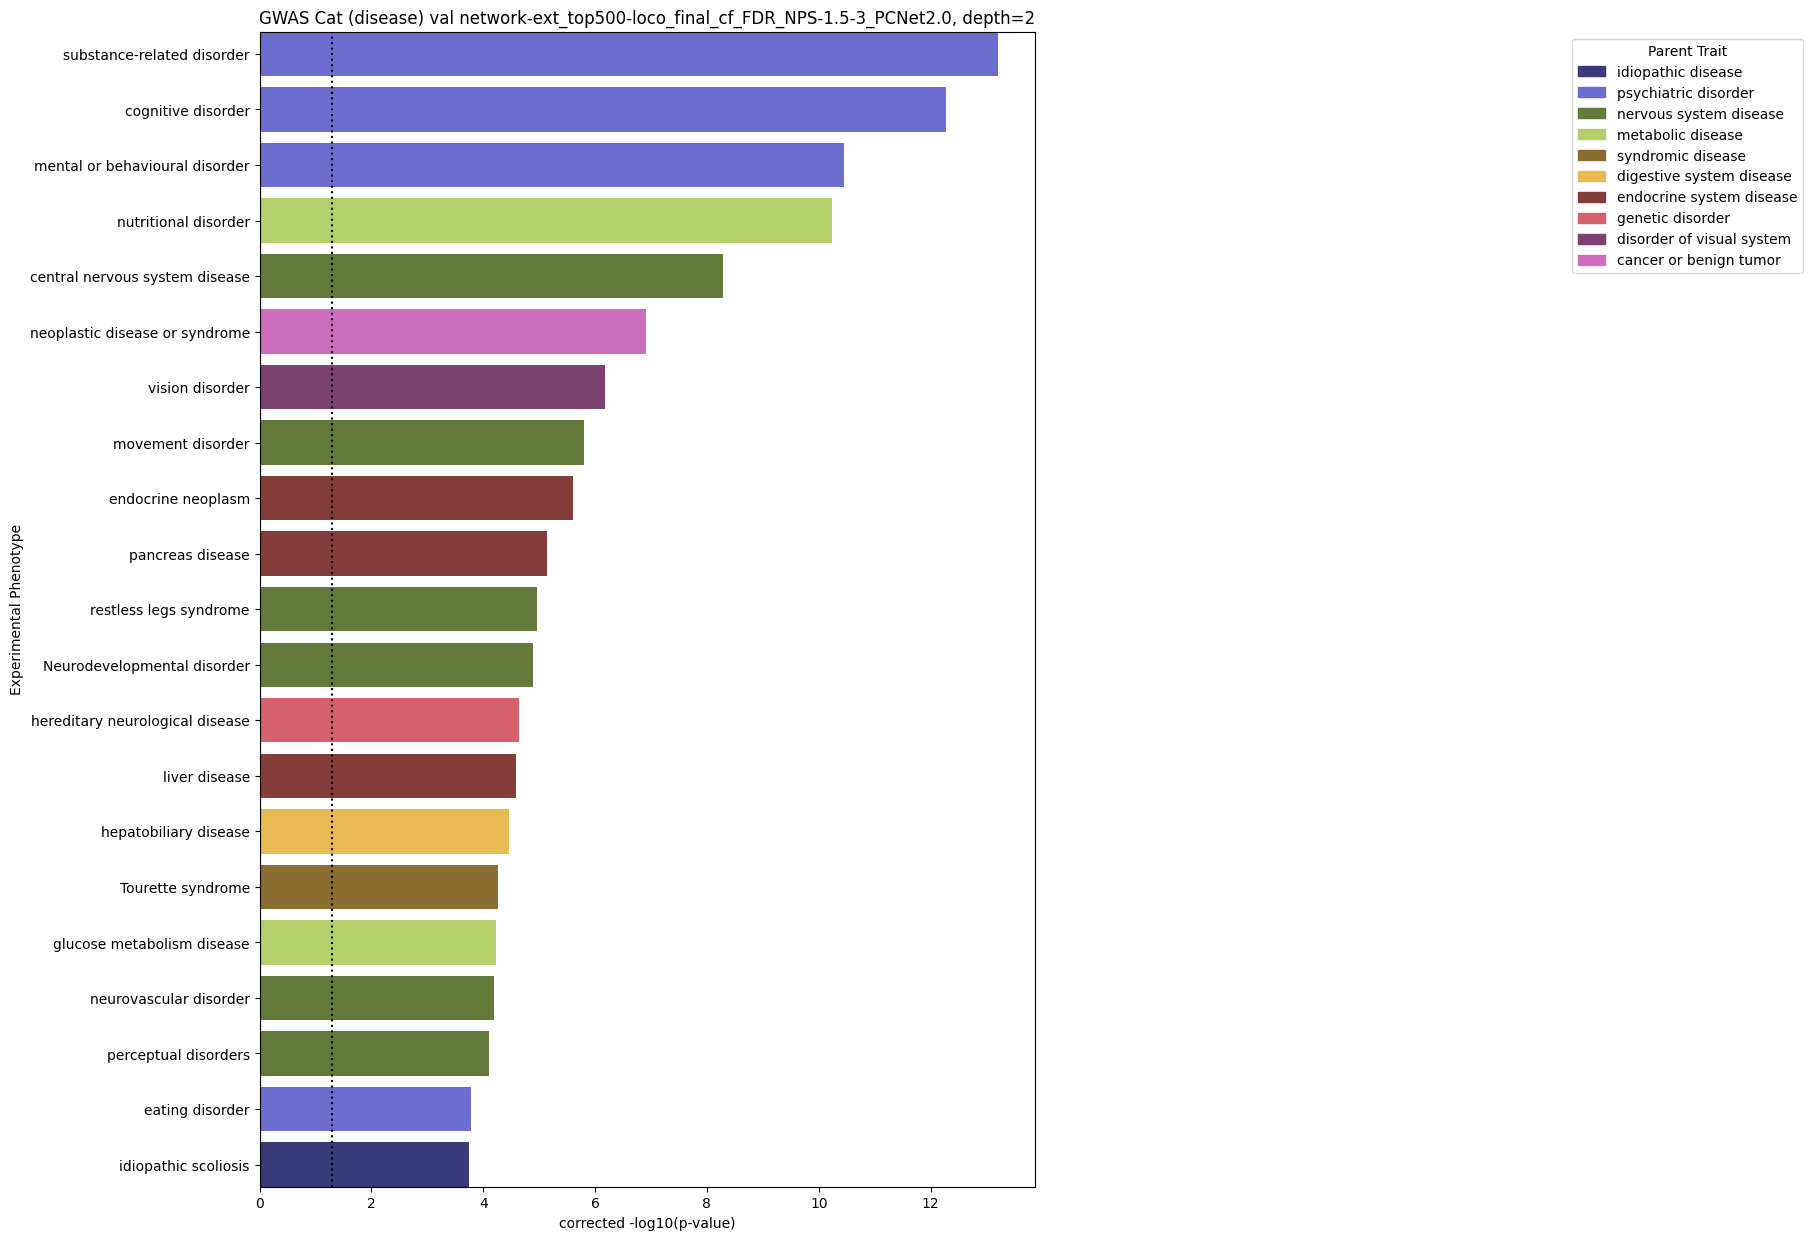

<Figure size 640x480 with 0 Axes>

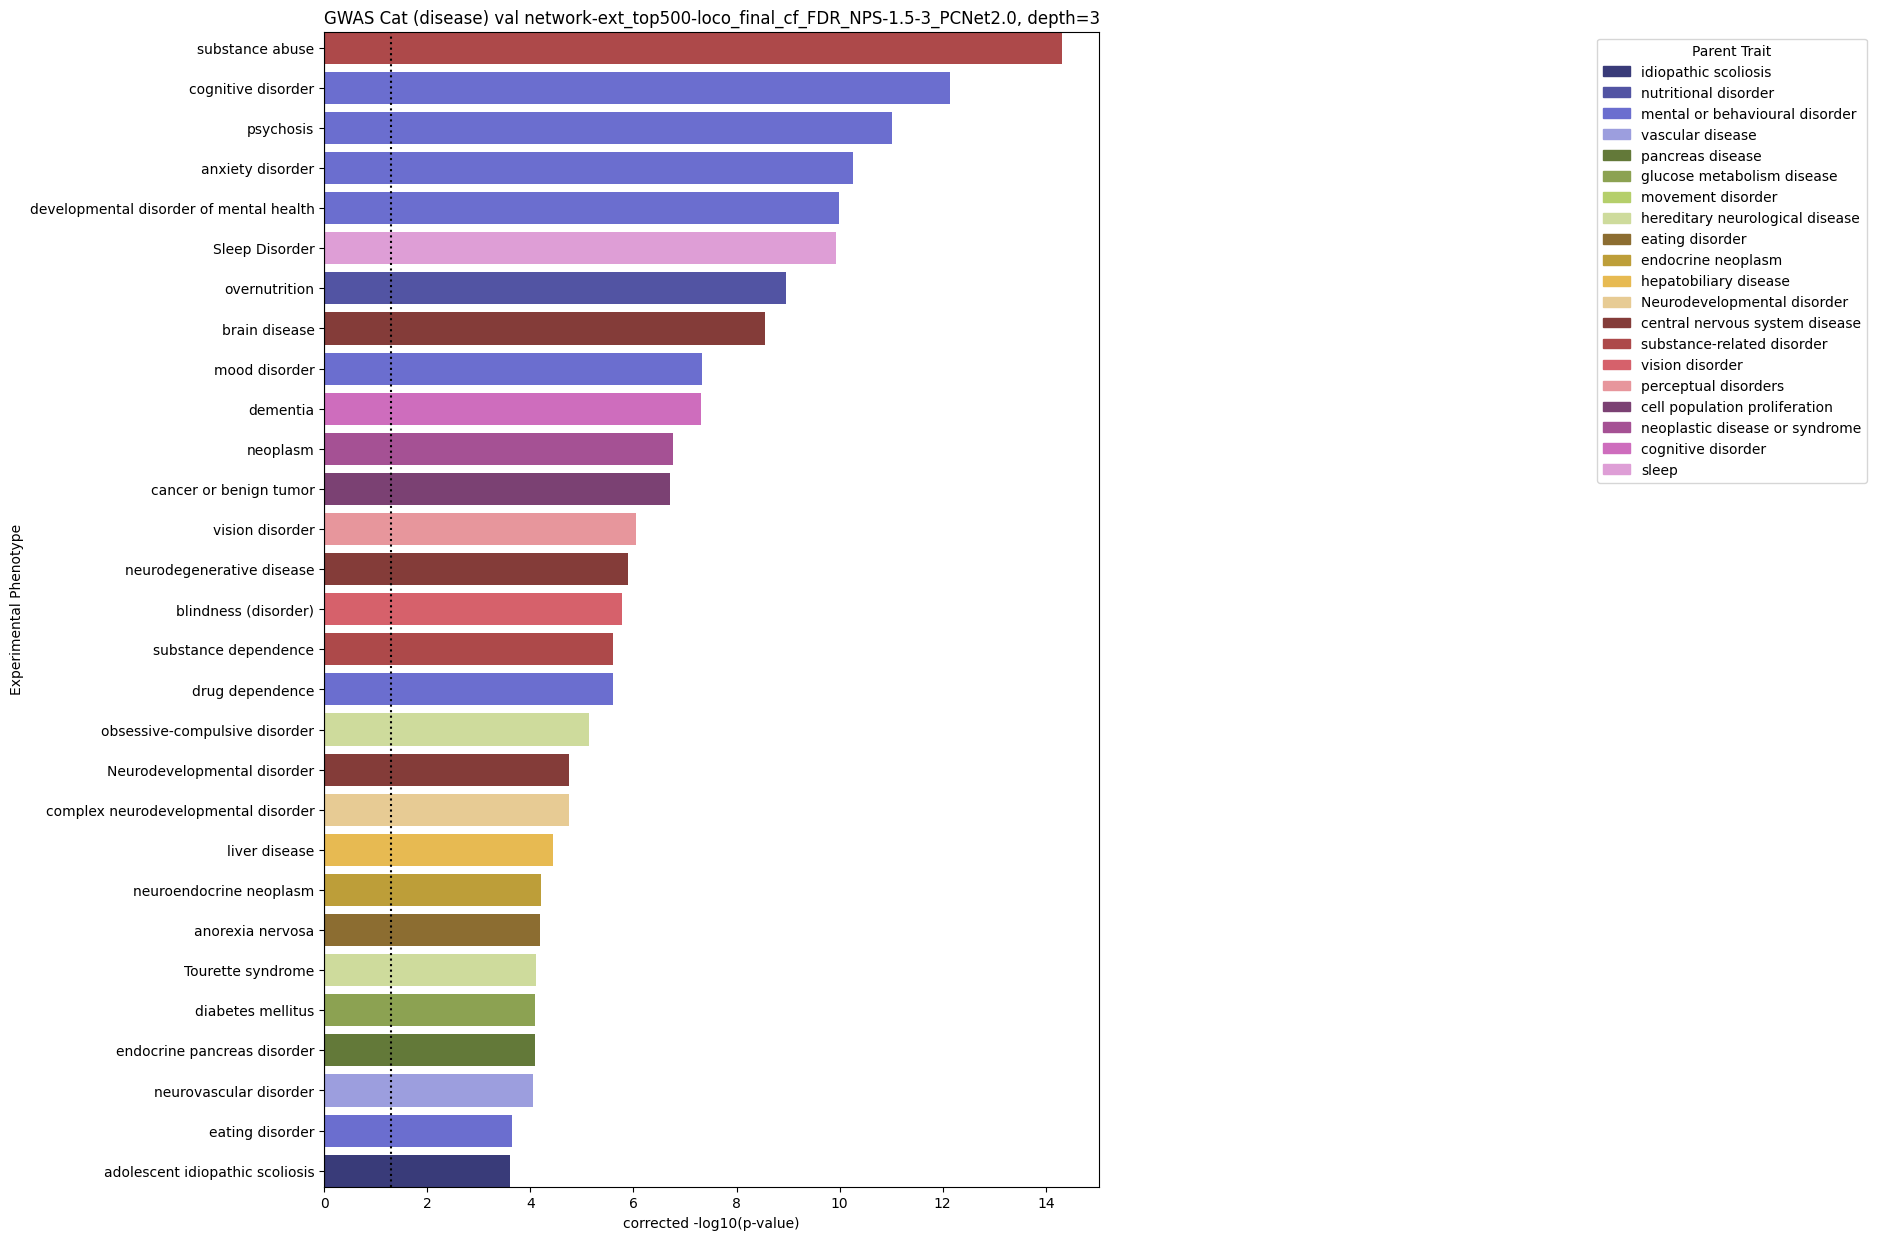

<Figure size 640x480 with 0 Axes>

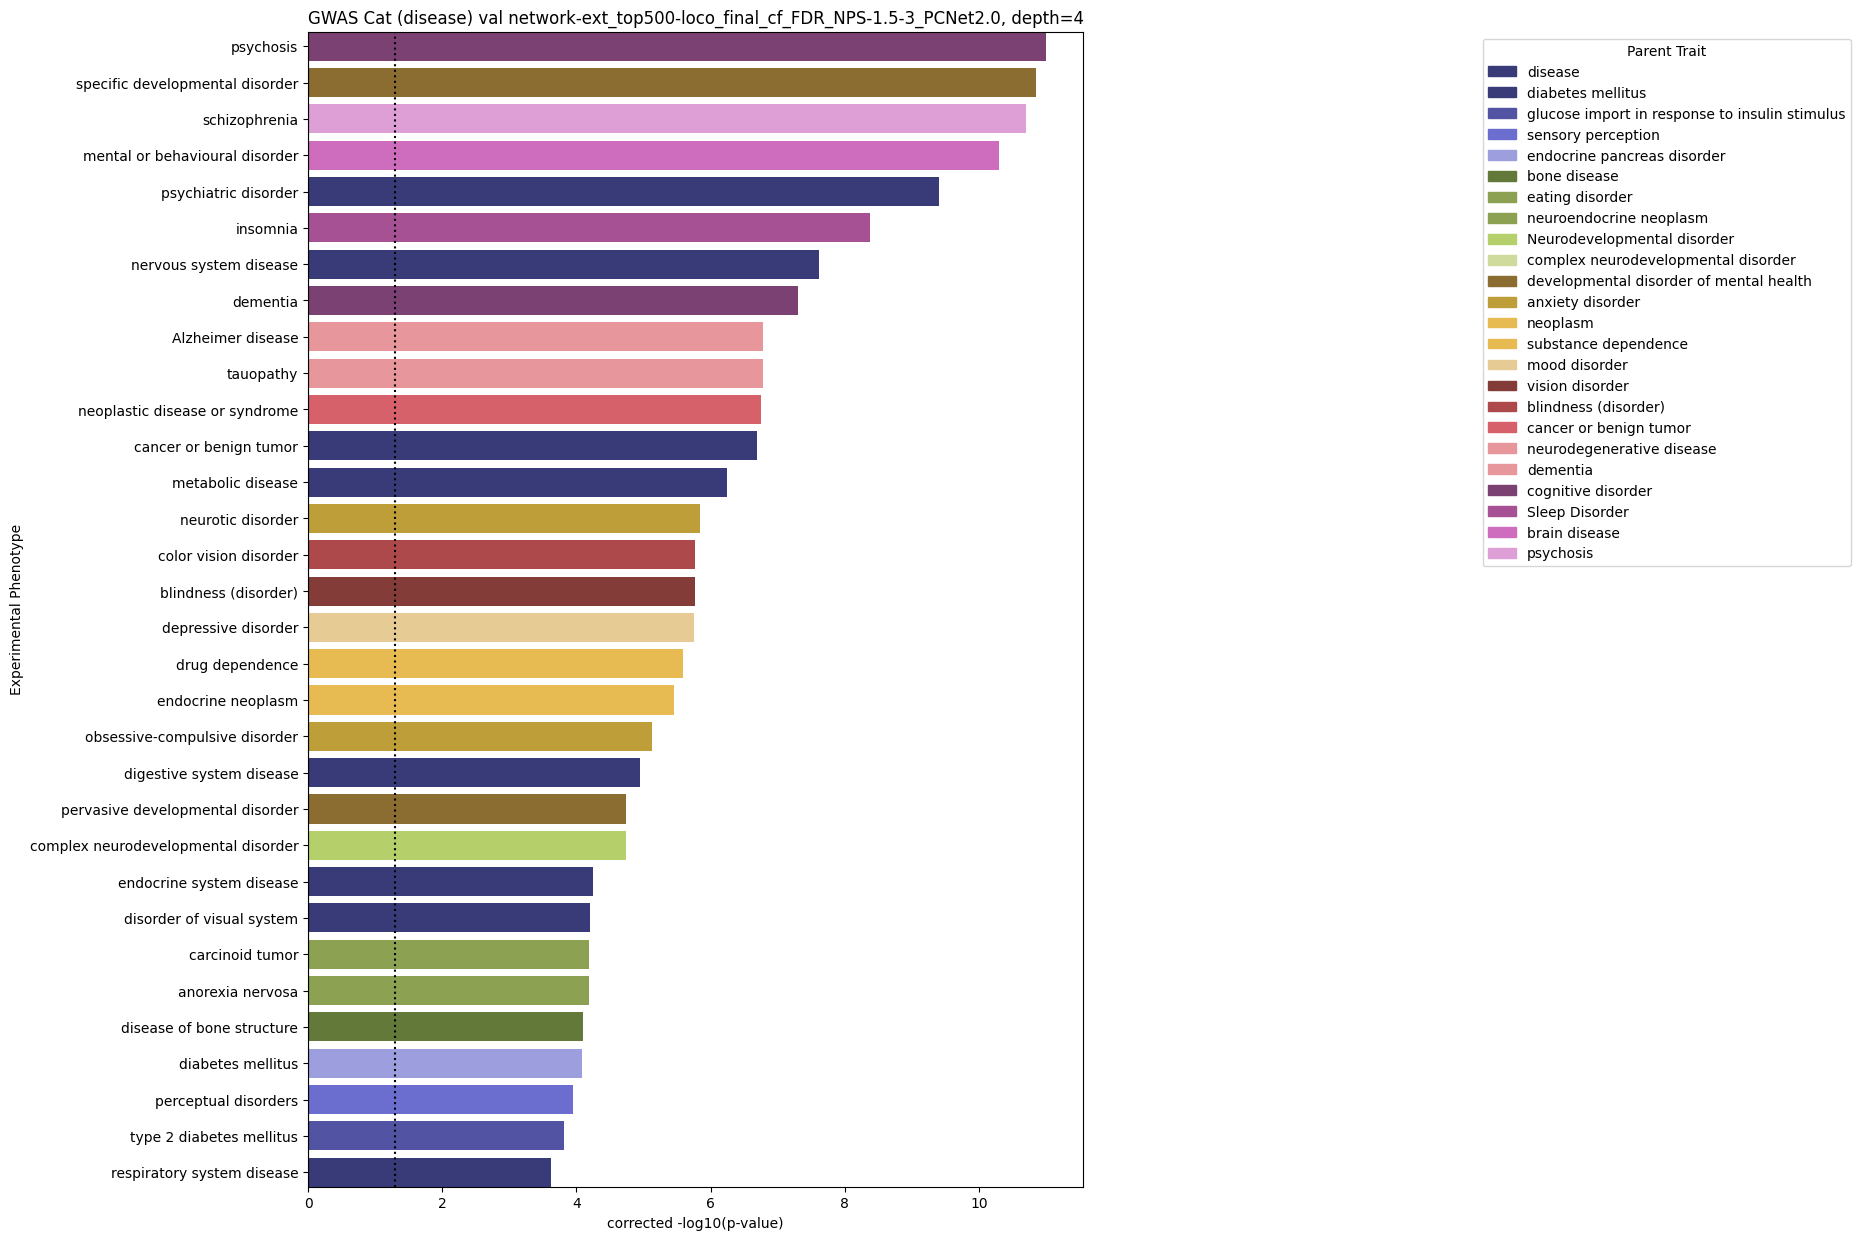

<Figure size 640x480 with 0 Axes>

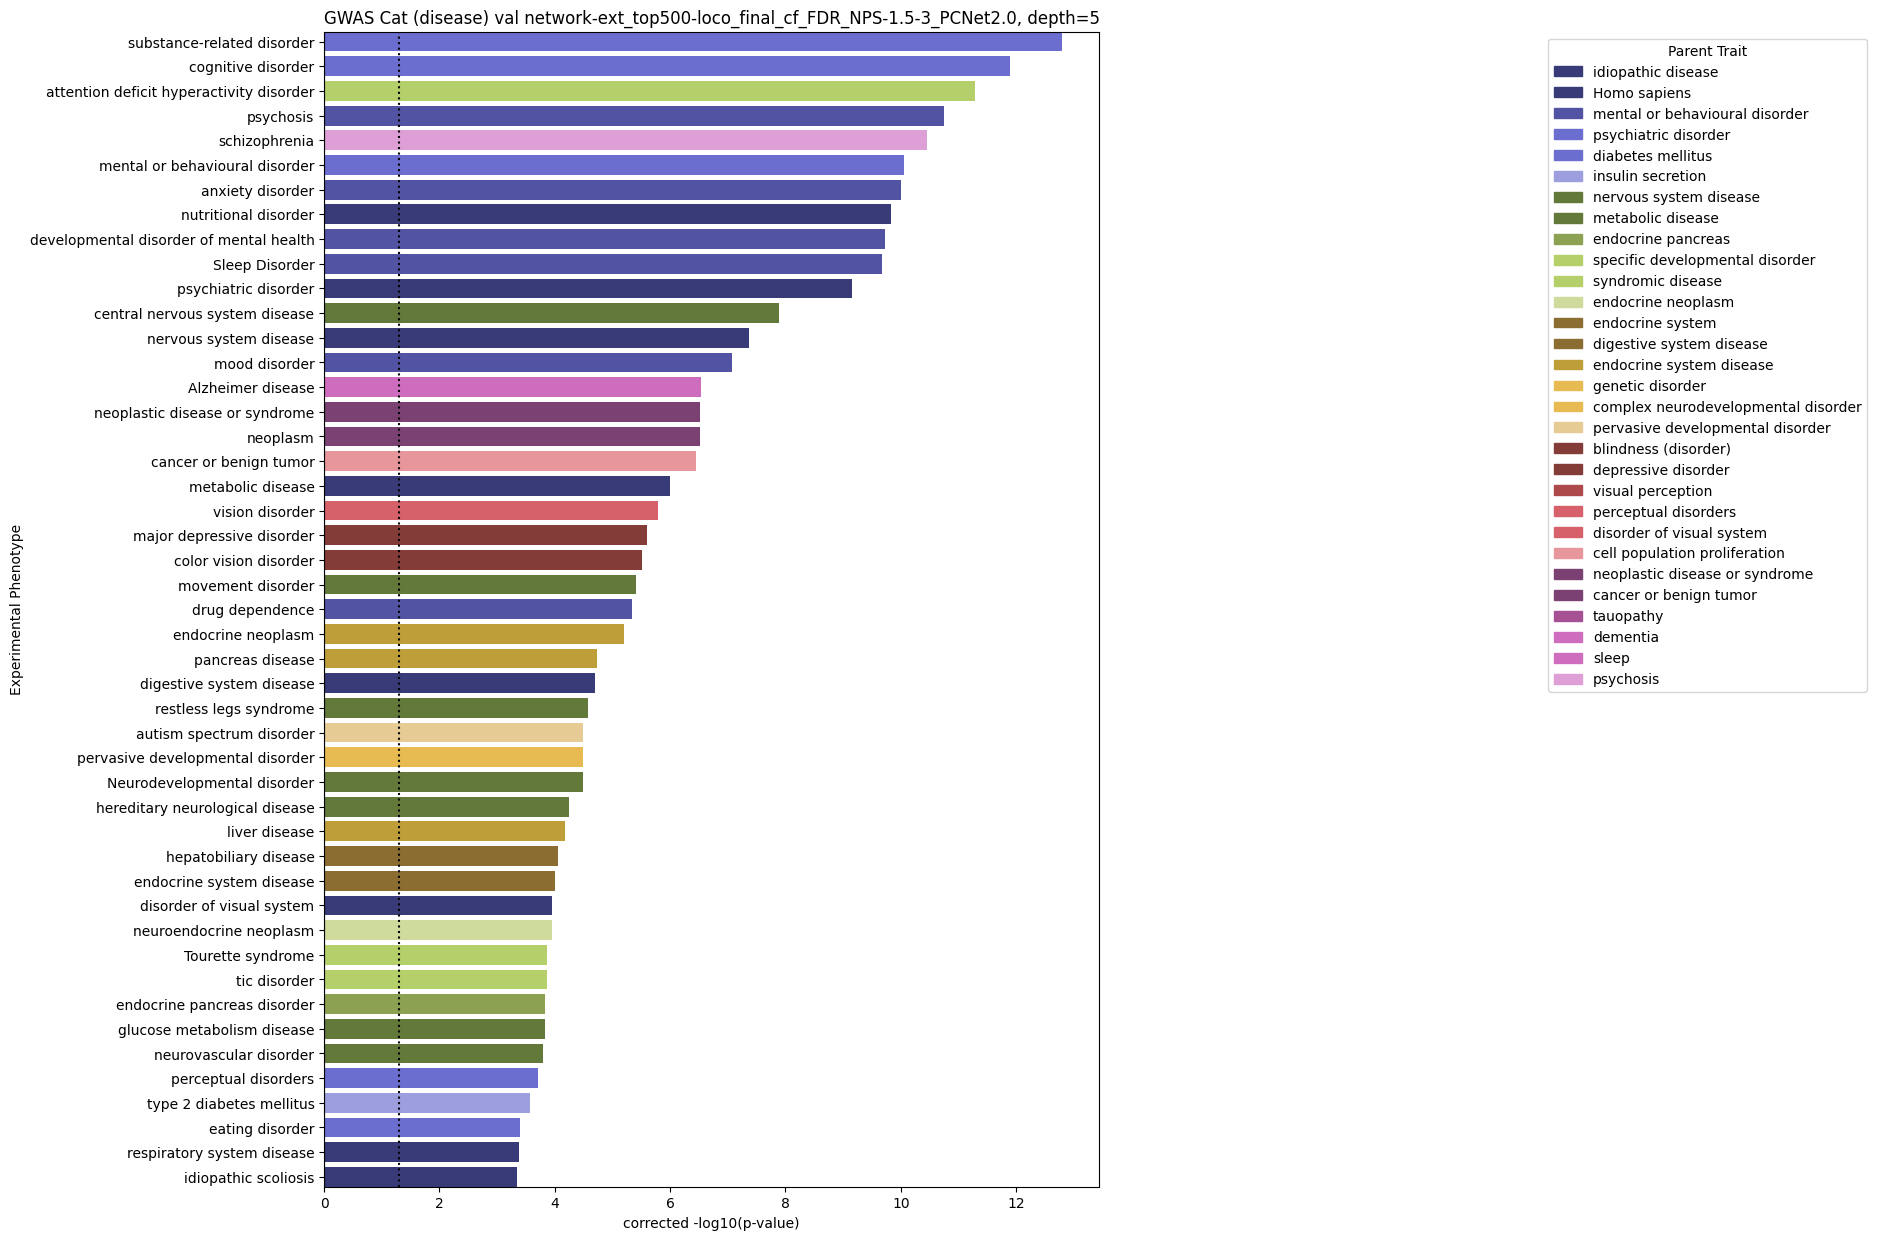

<Figure size 640x480 with 0 Axes>

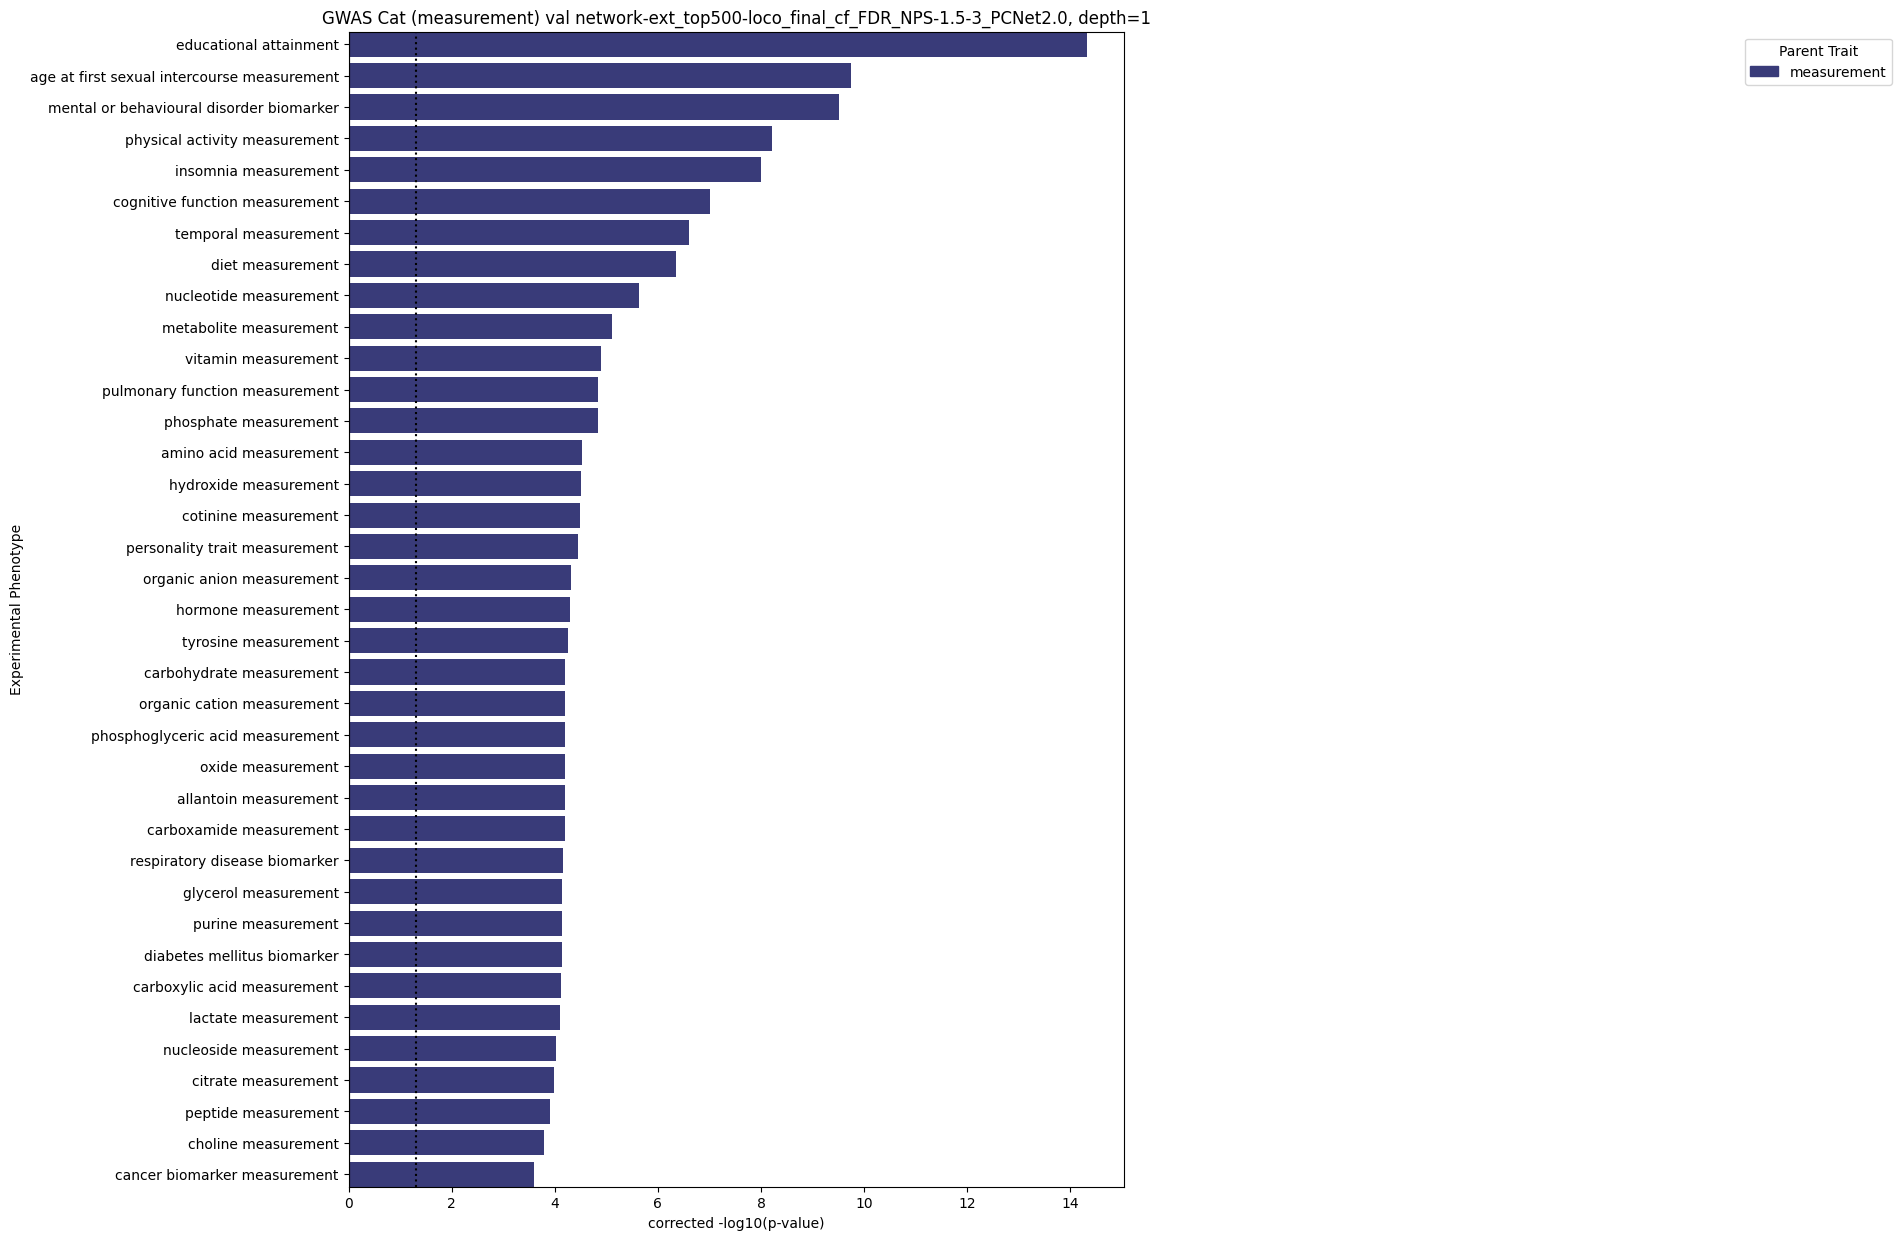

<Figure size 640x480 with 0 Axes>

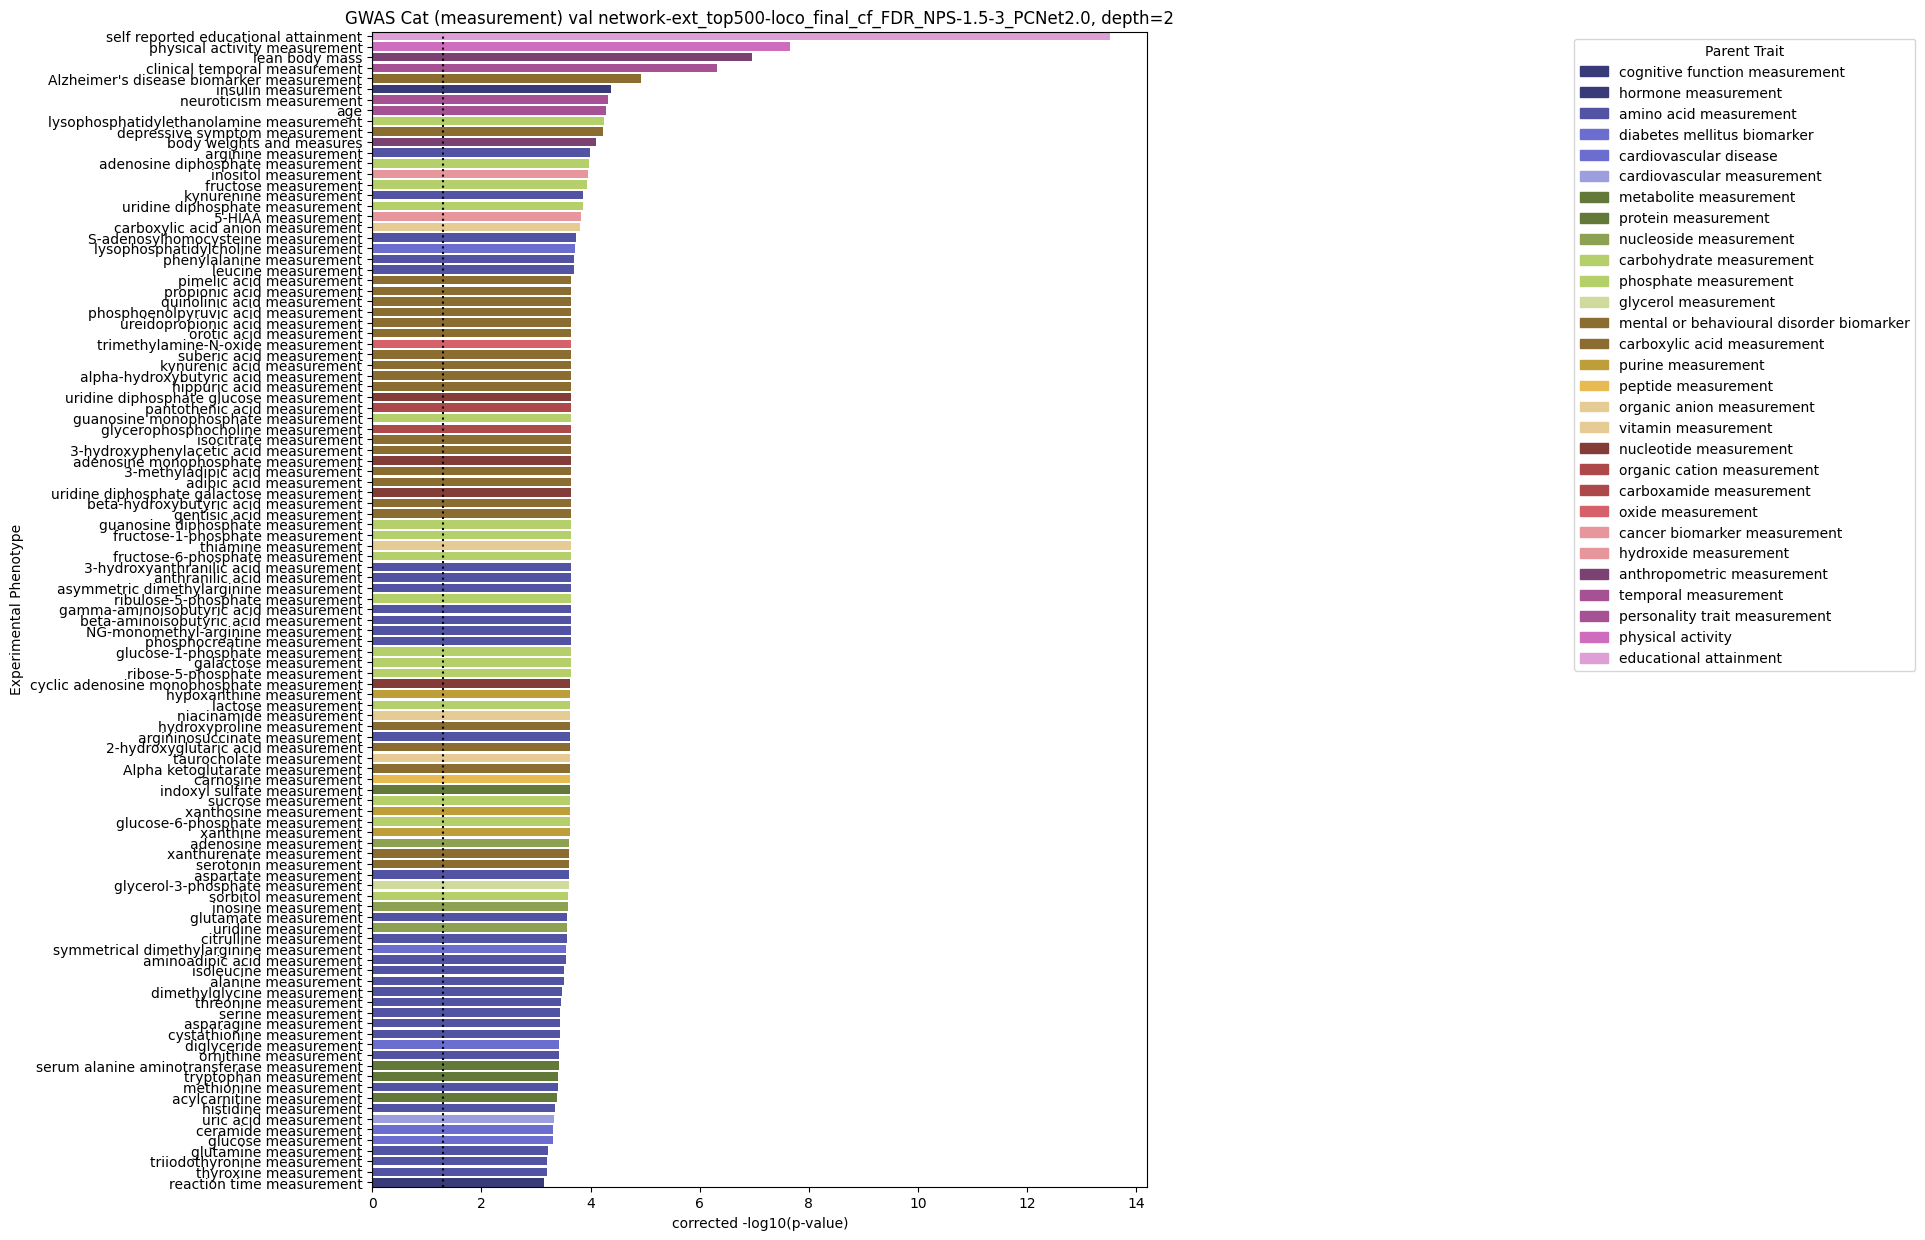

<Figure size 640x480 with 0 Axes>

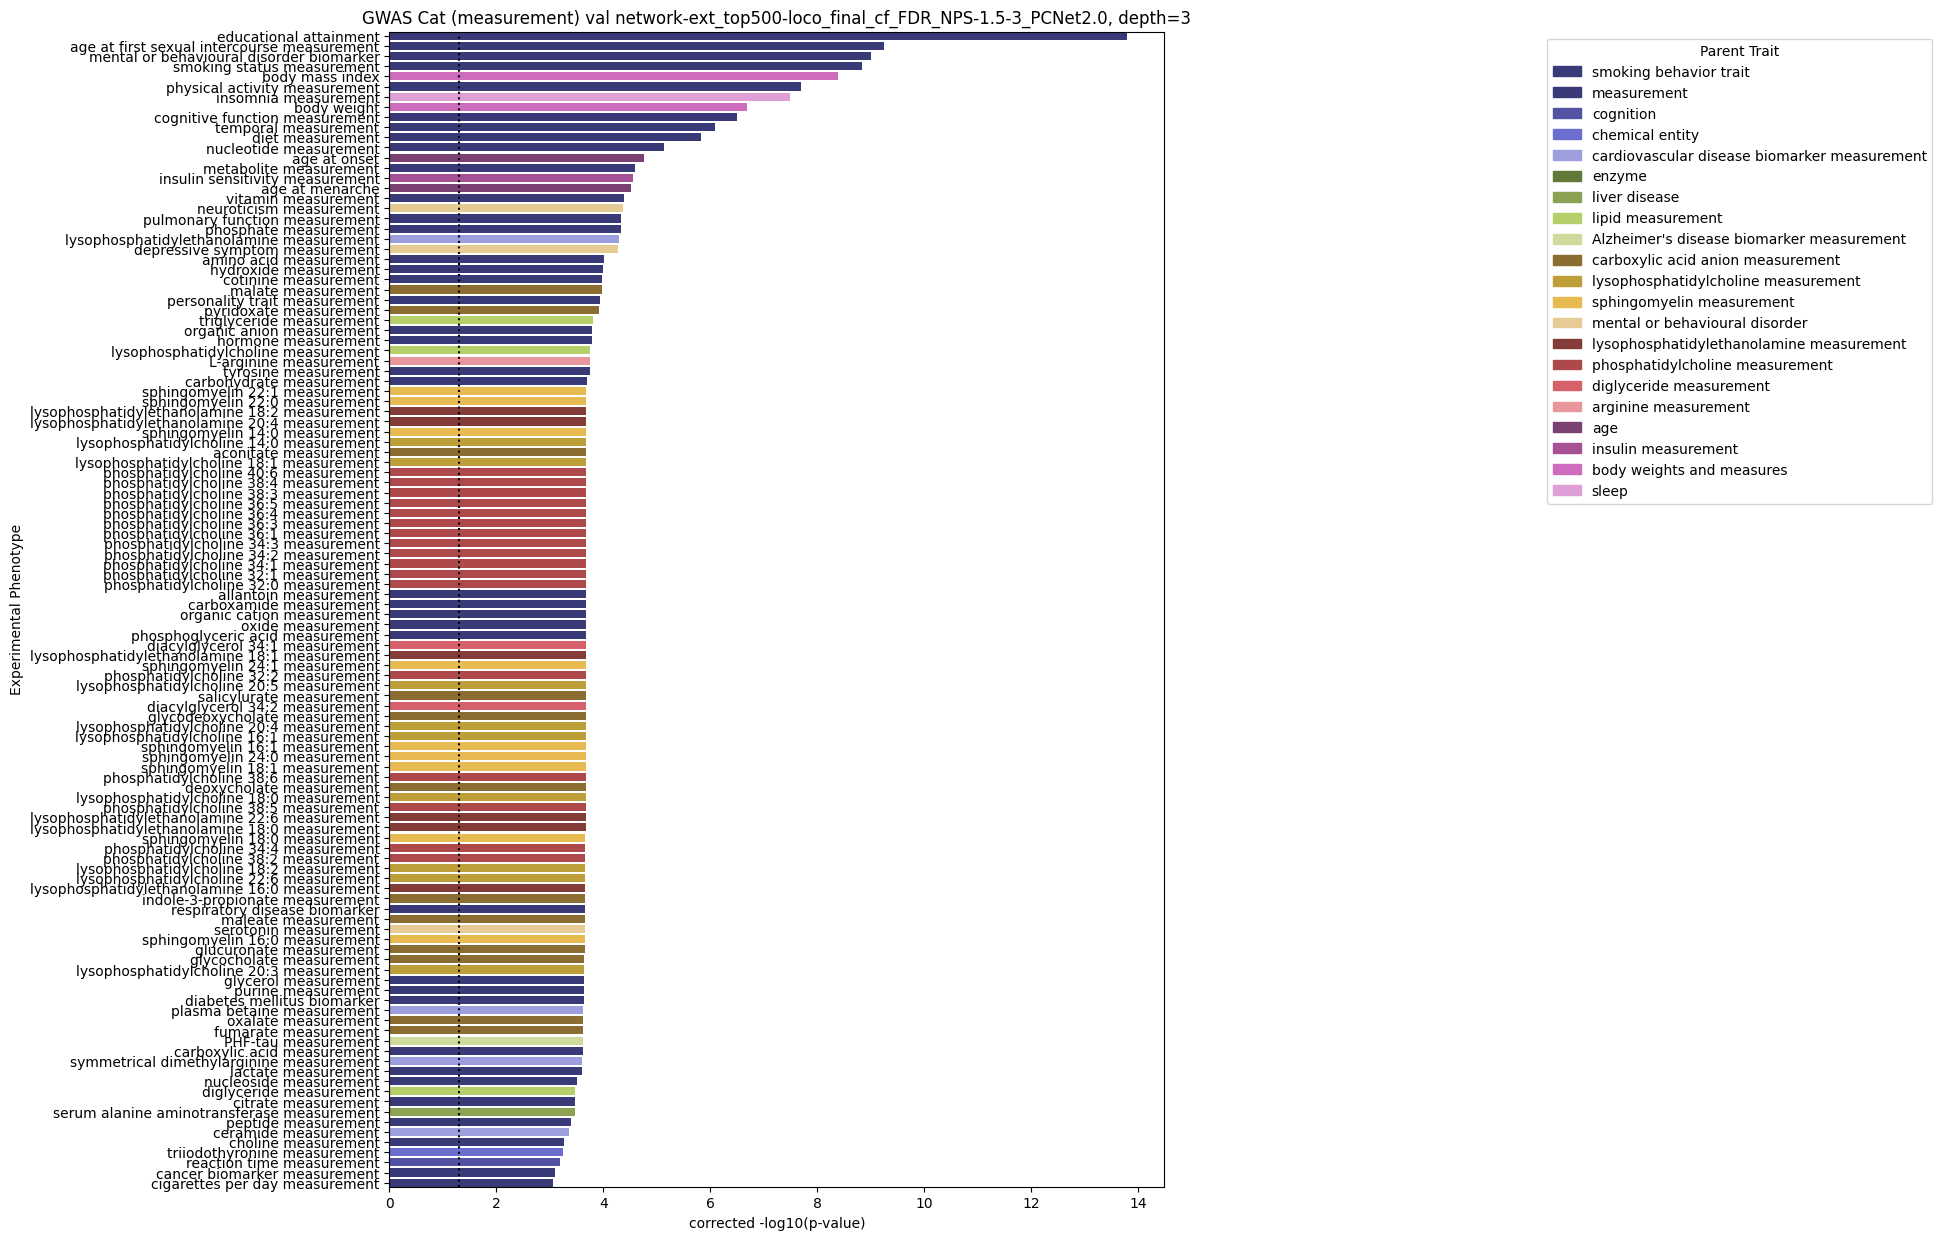

<Figure size 640x480 with 0 Axes>

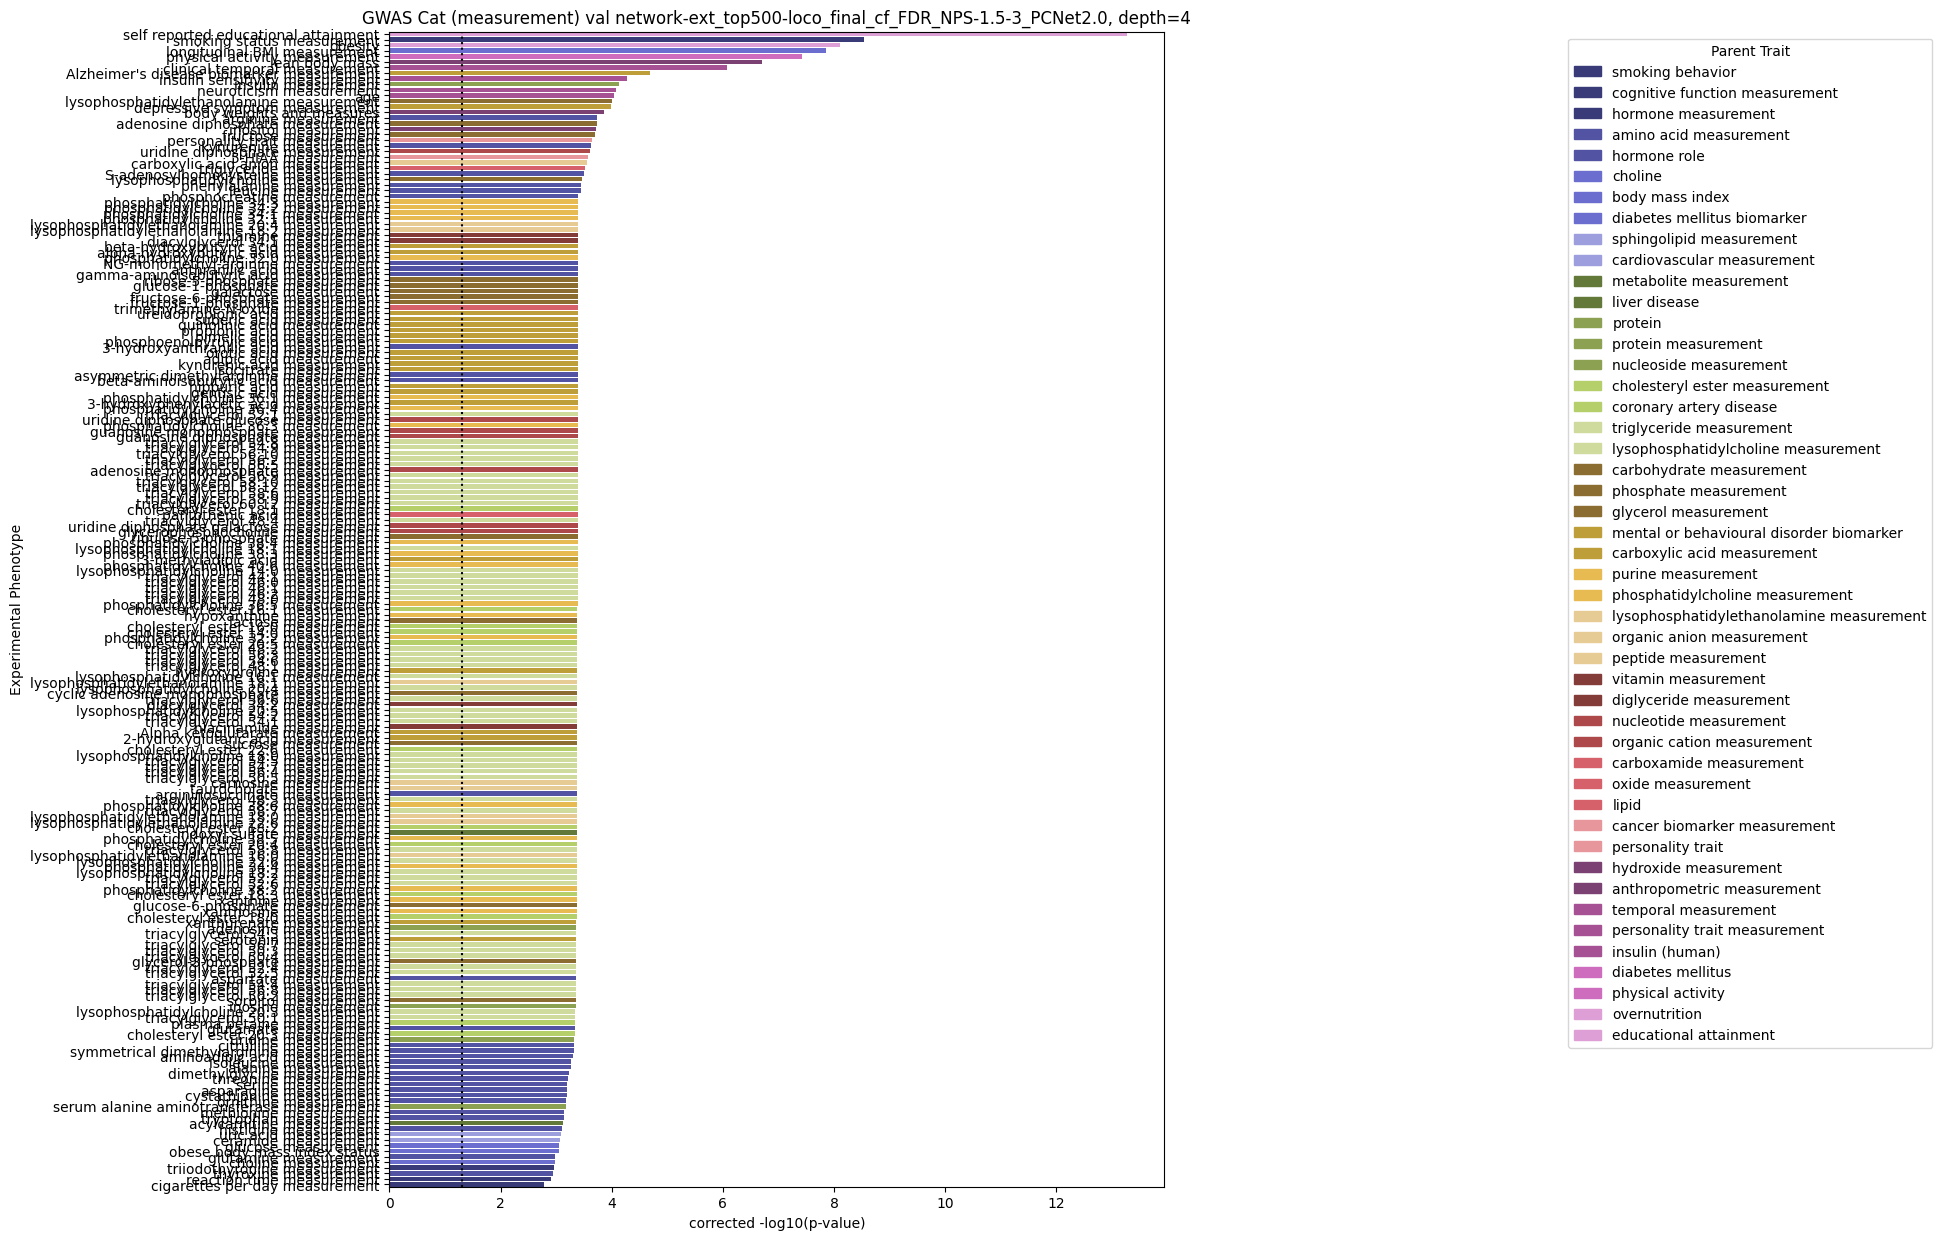

<Figure size 640x480 with 0 Axes>

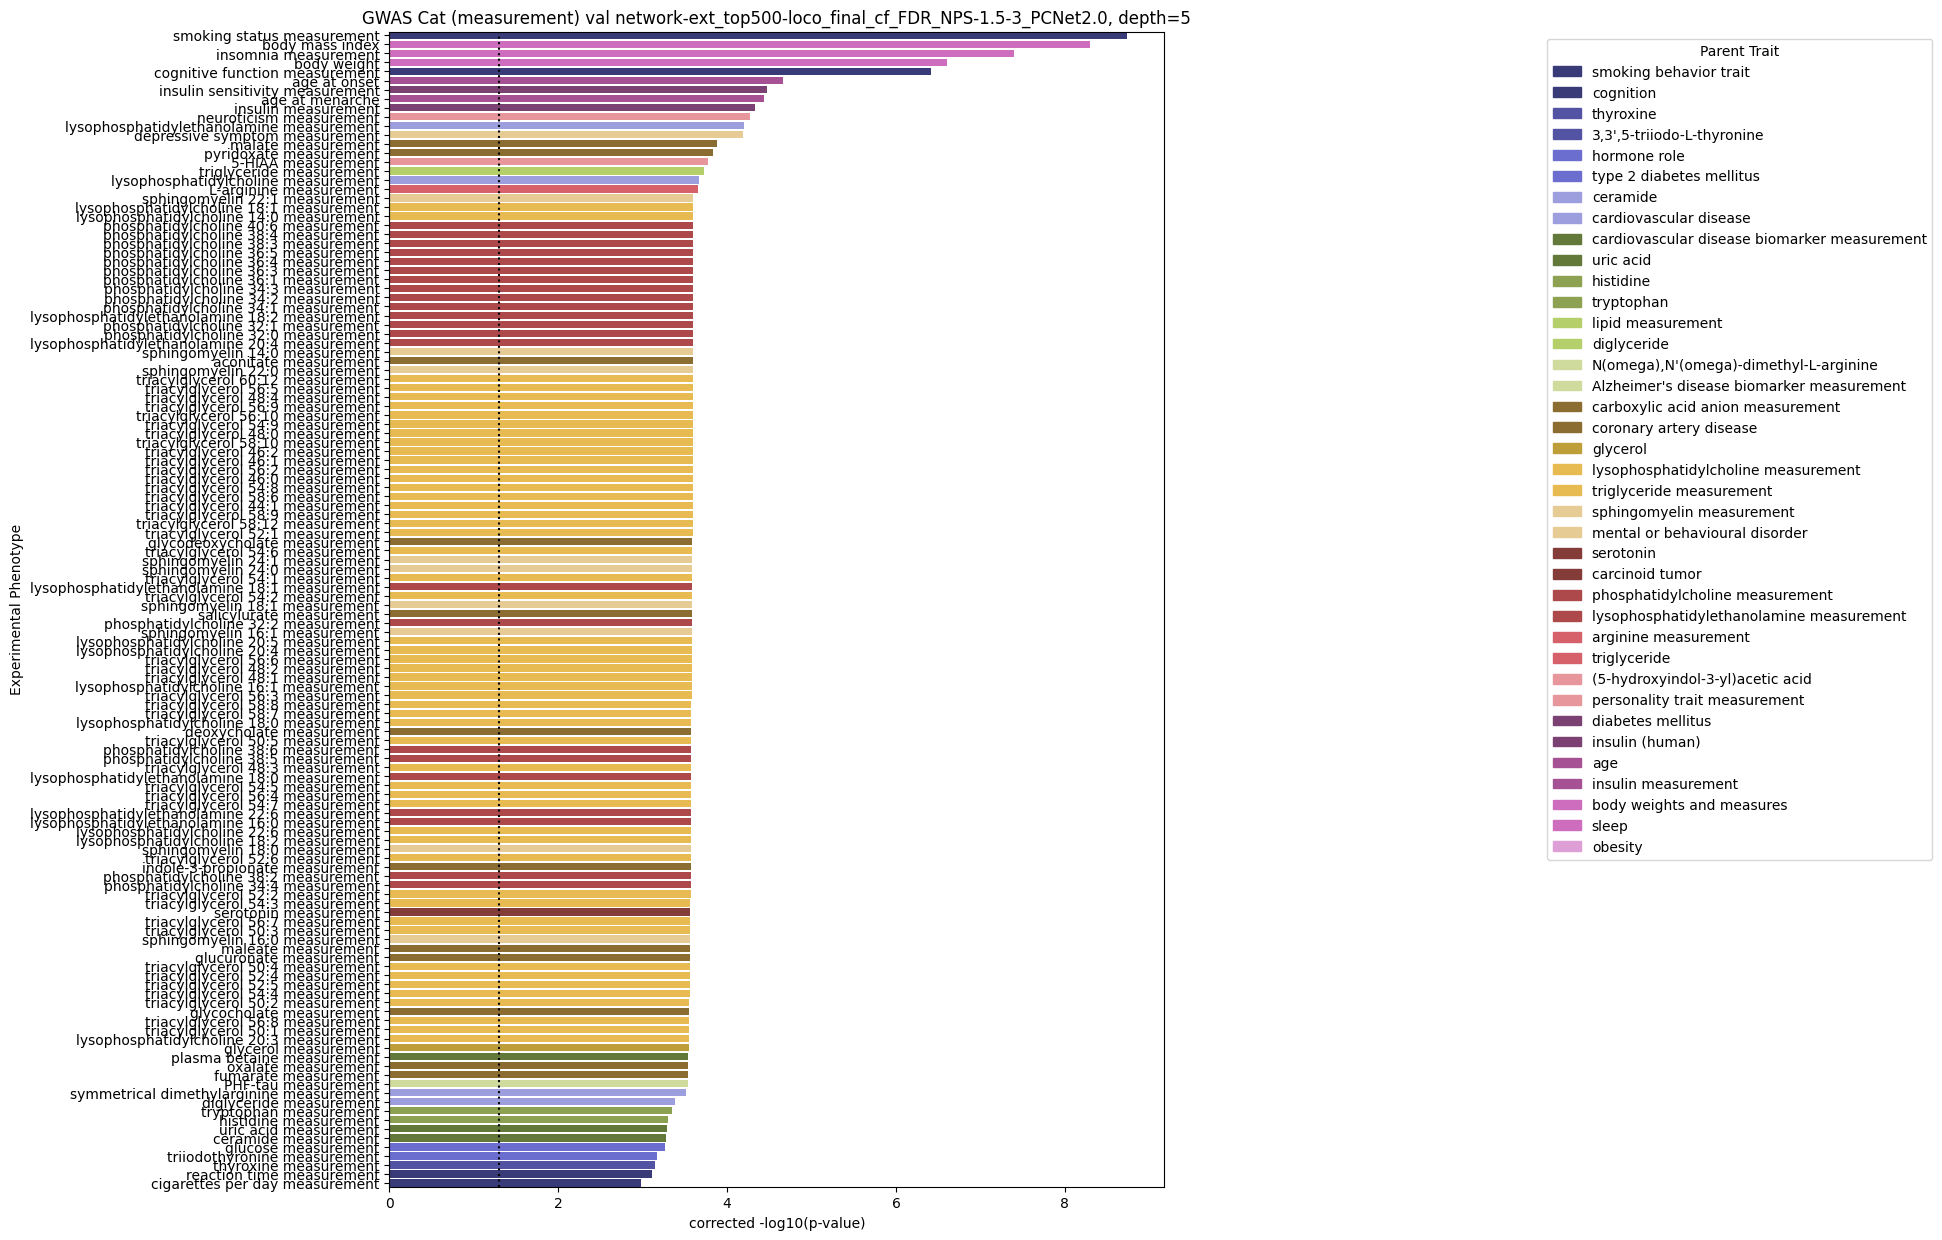

<Figure size 640x480 with 0 Axes>

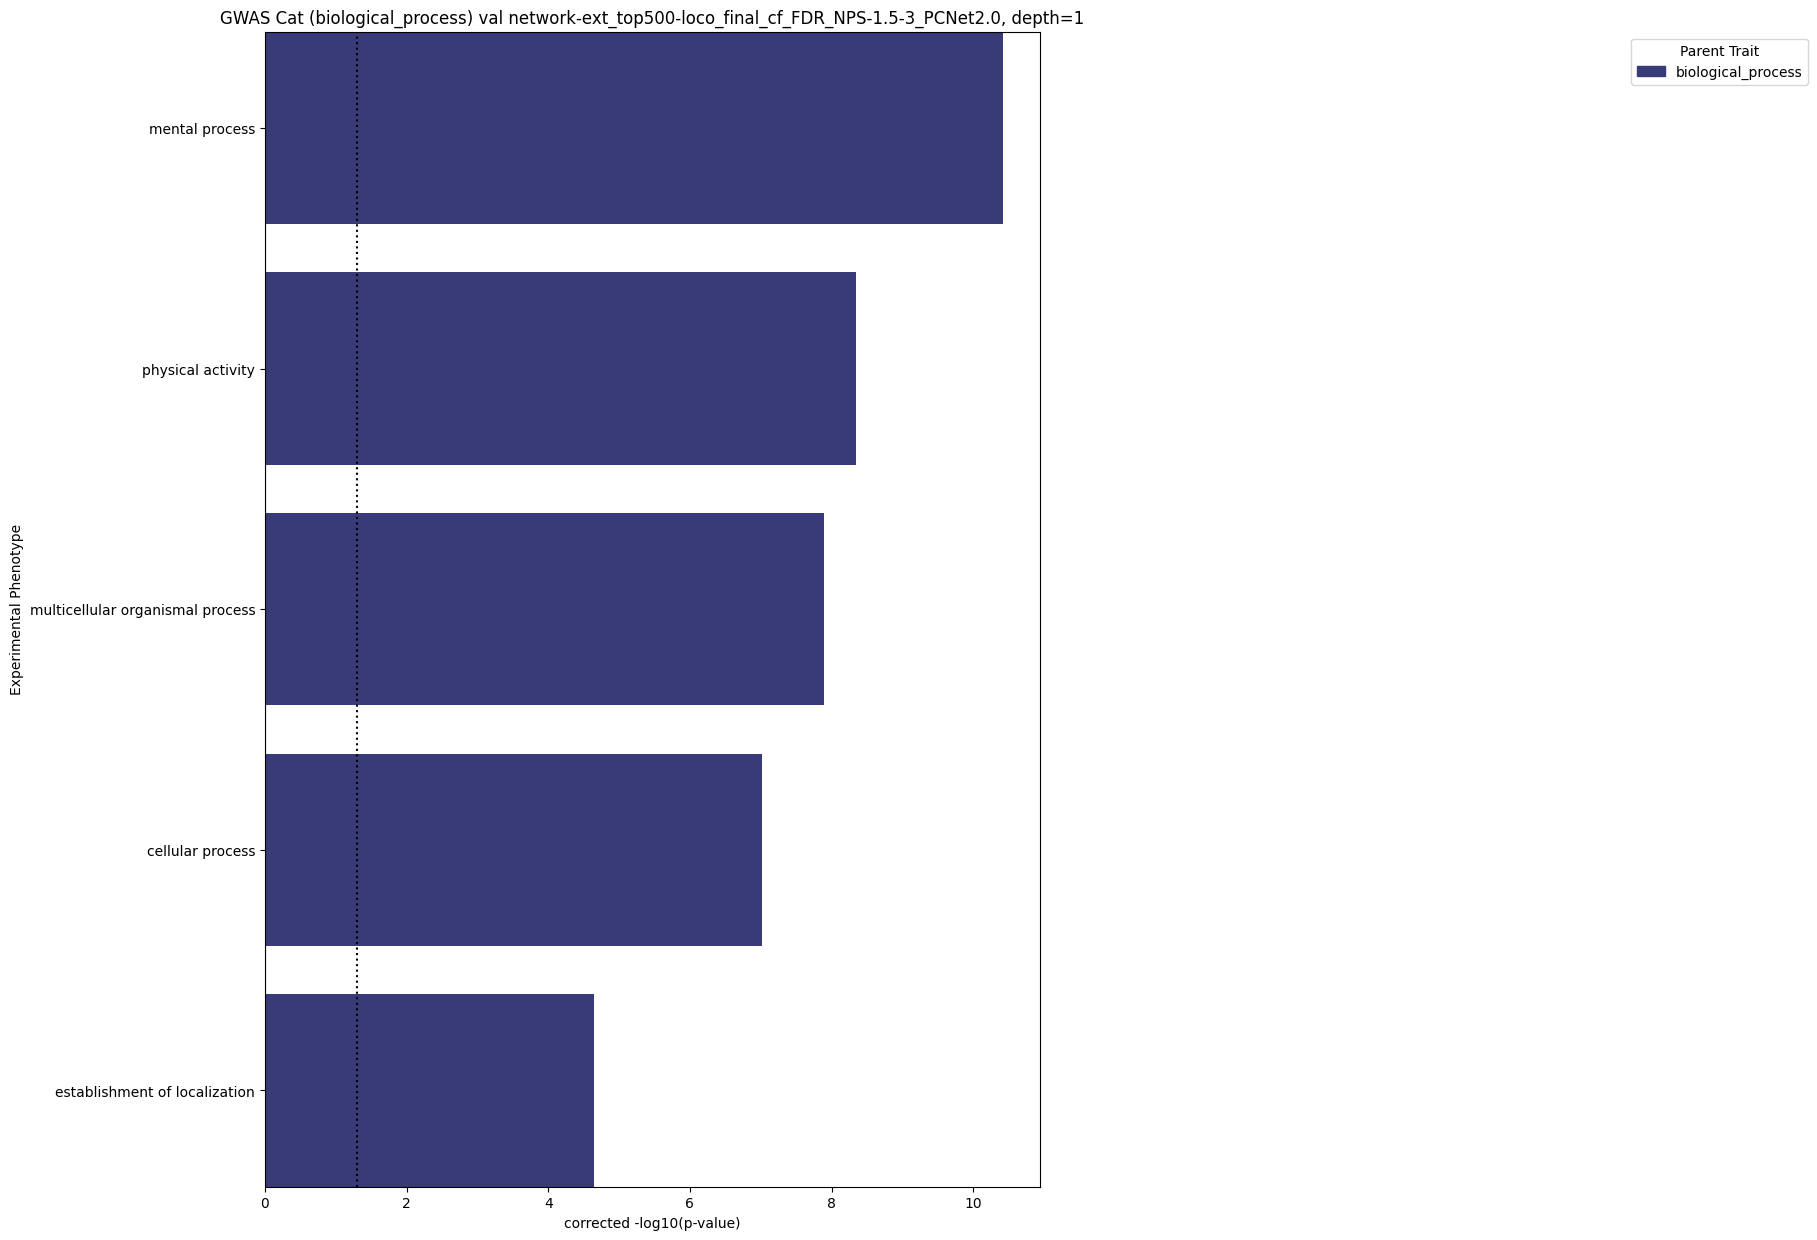

<Figure size 640x480 with 0 Axes>

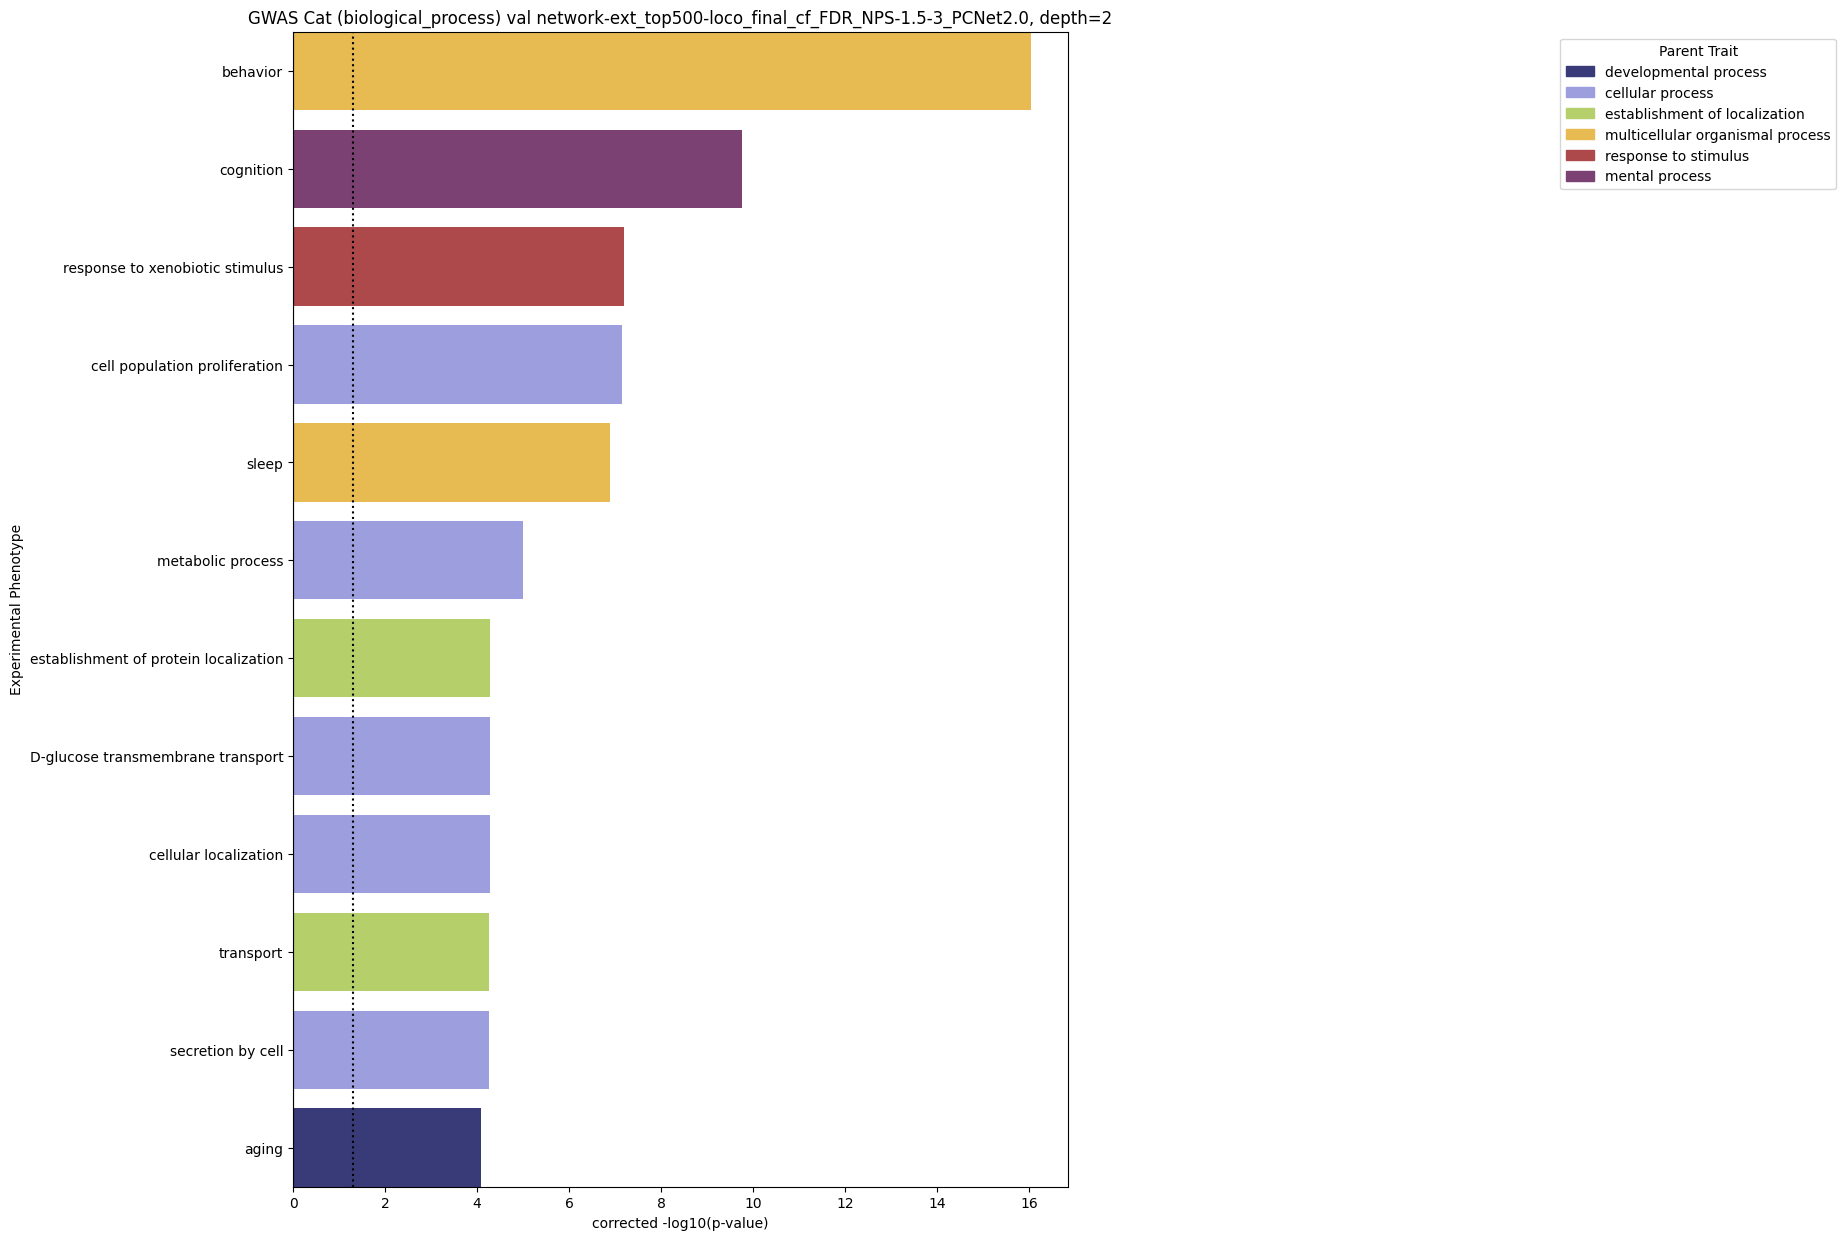

<Figure size 640x480 with 0 Axes>

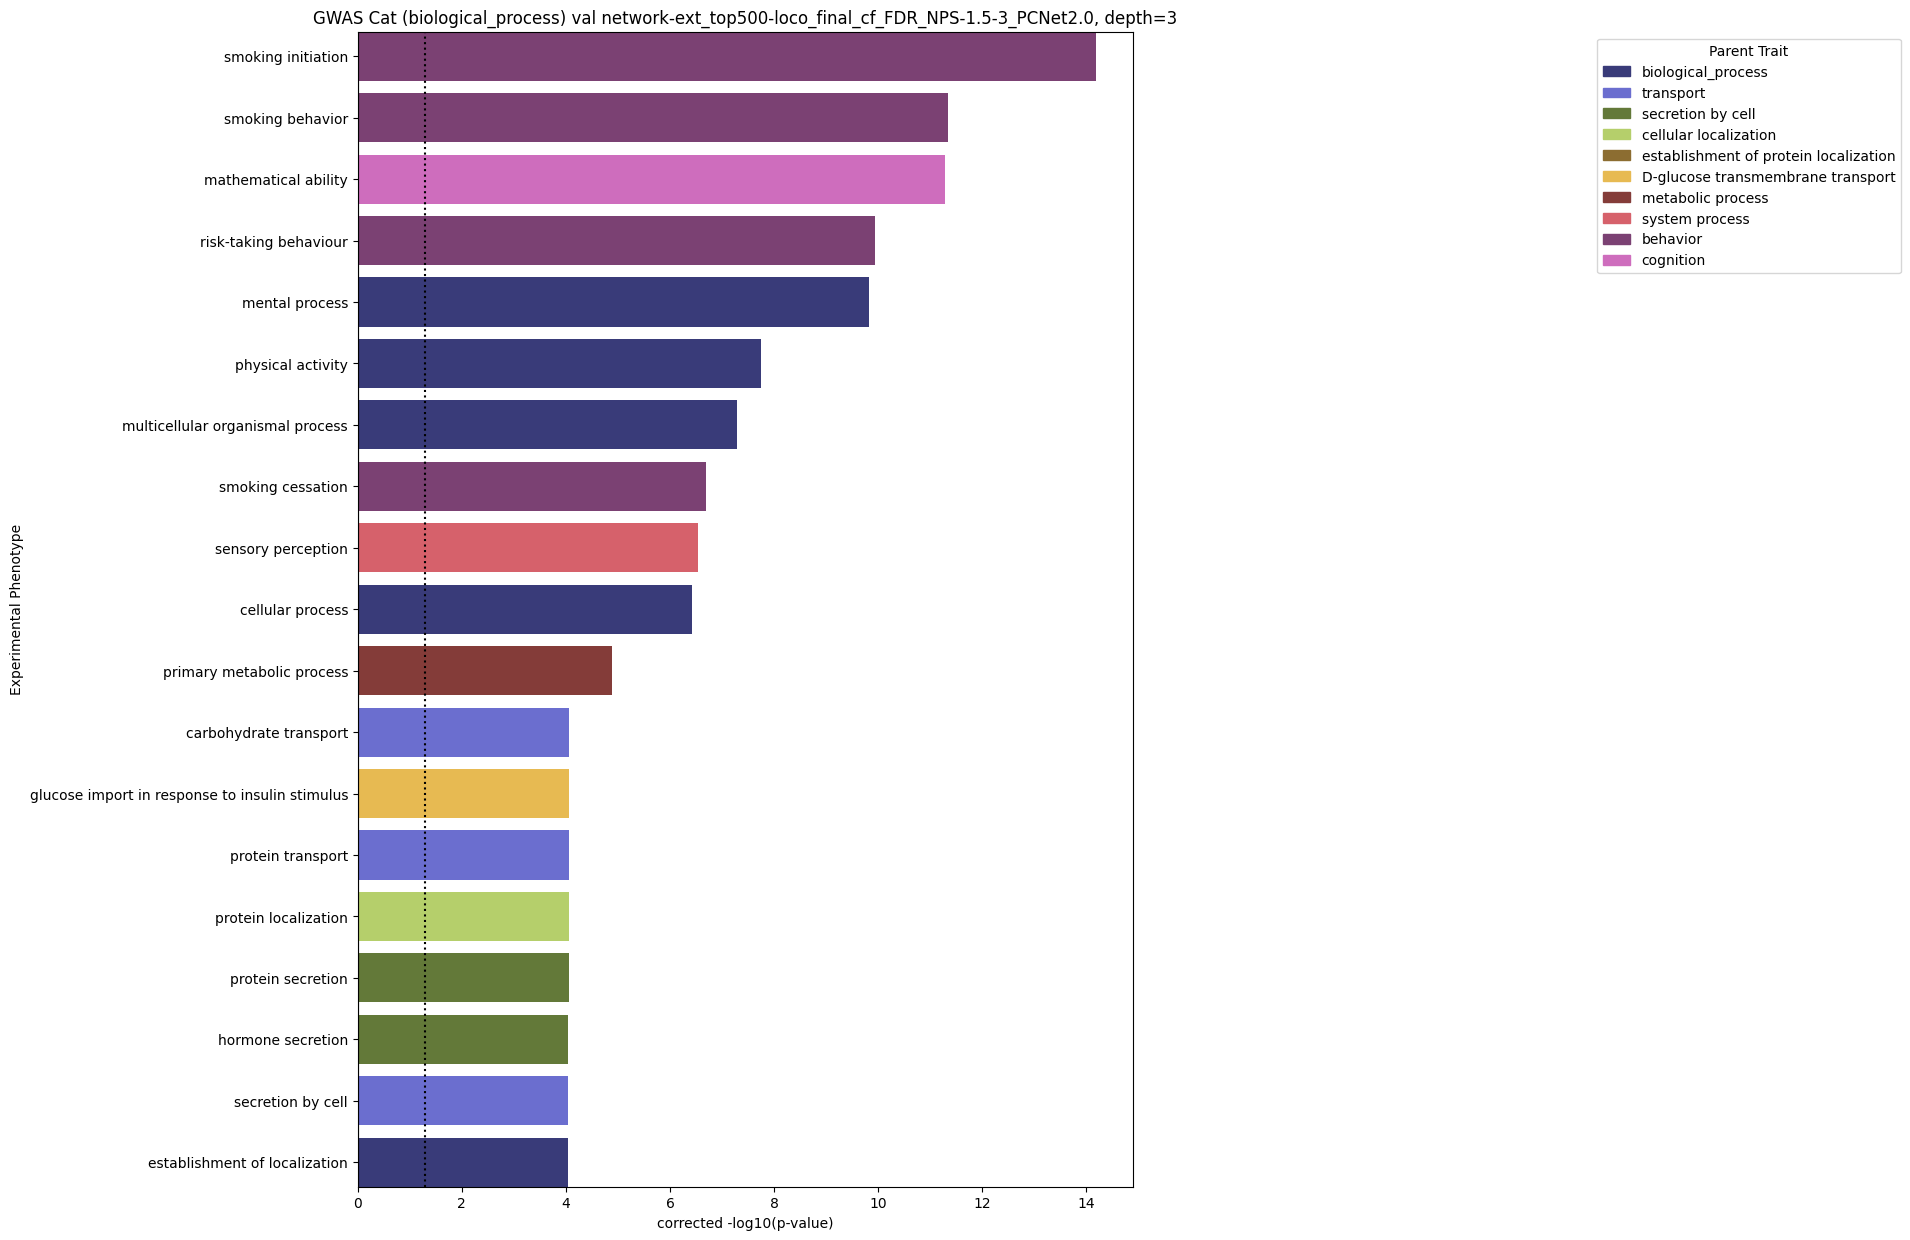

<Figure size 640x480 with 0 Axes>

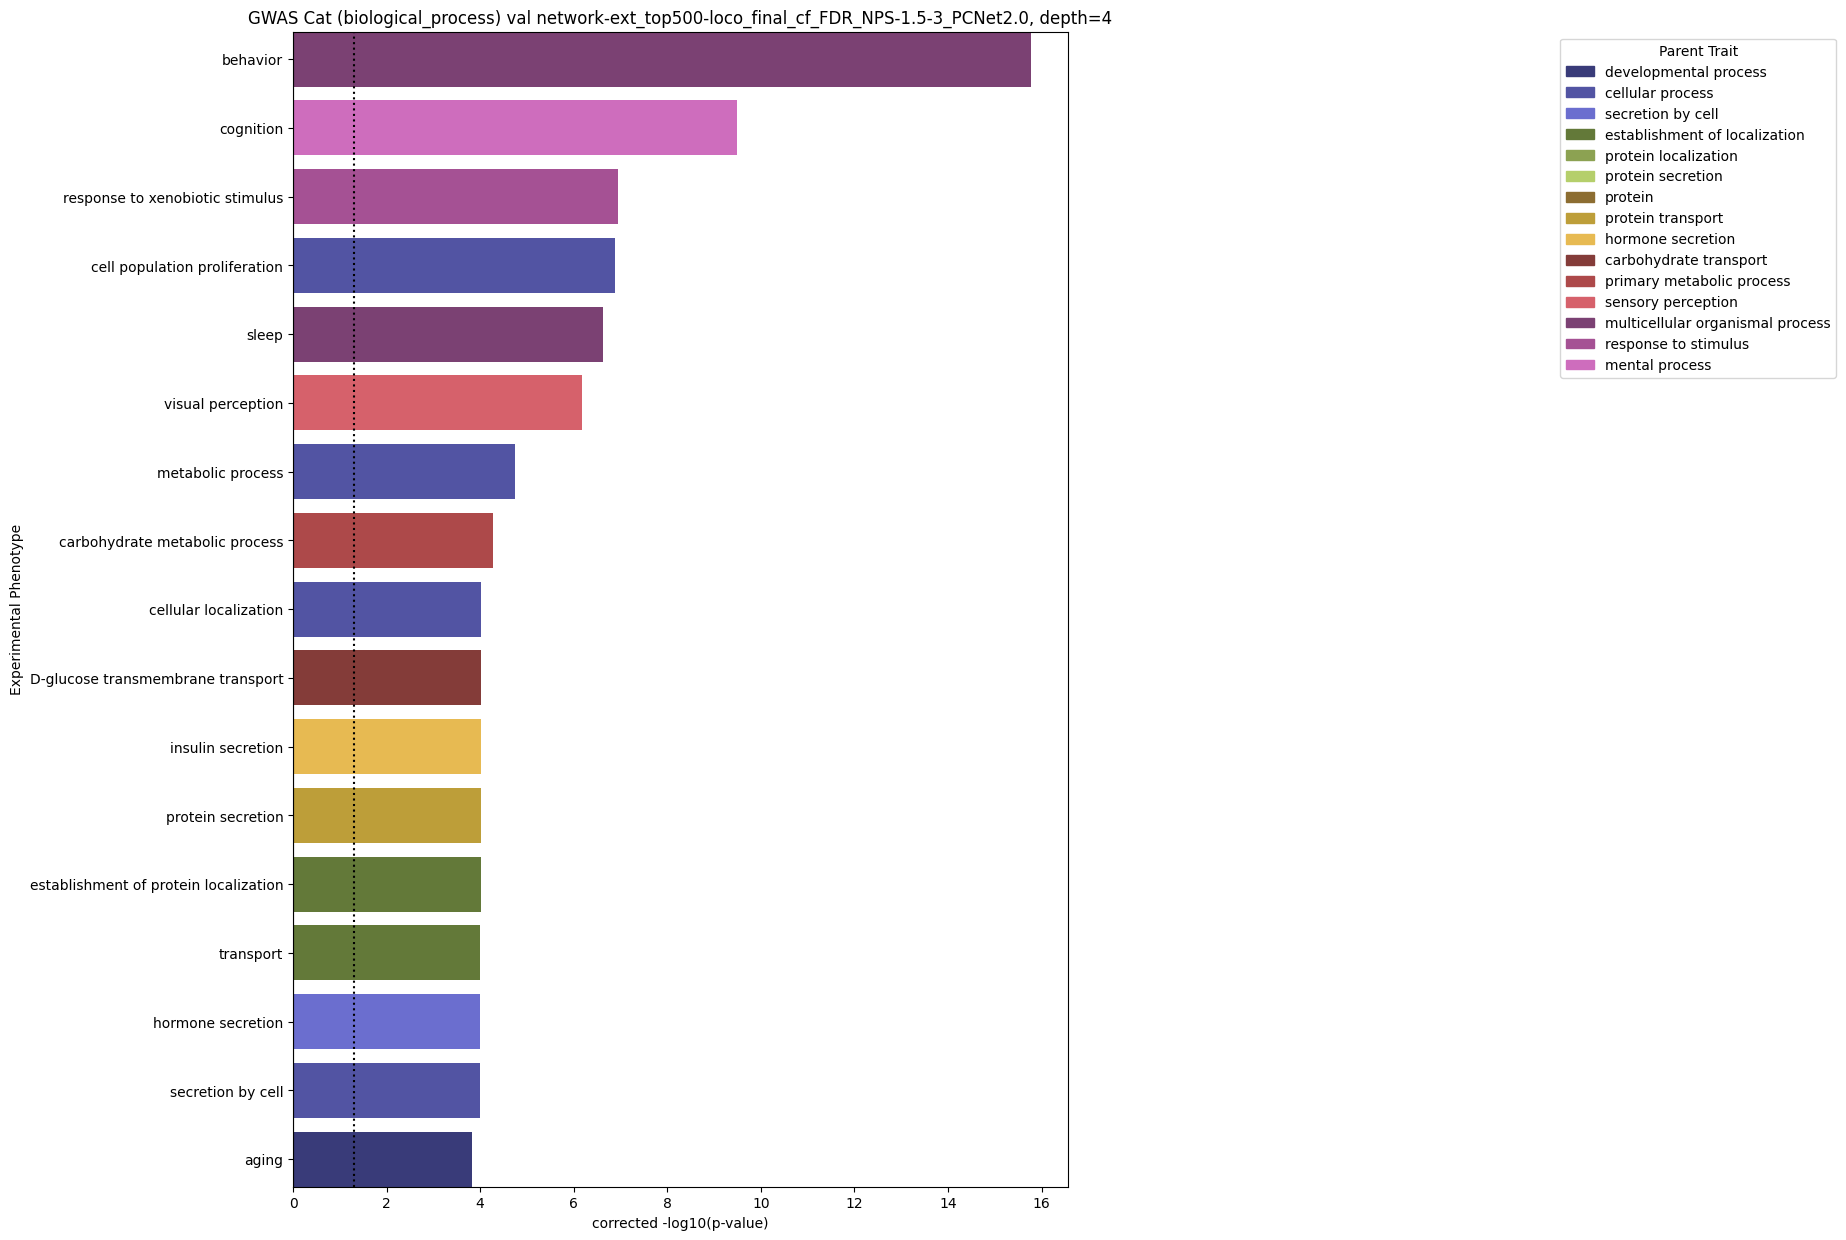

<Figure size 640x480 with 0 Axes>

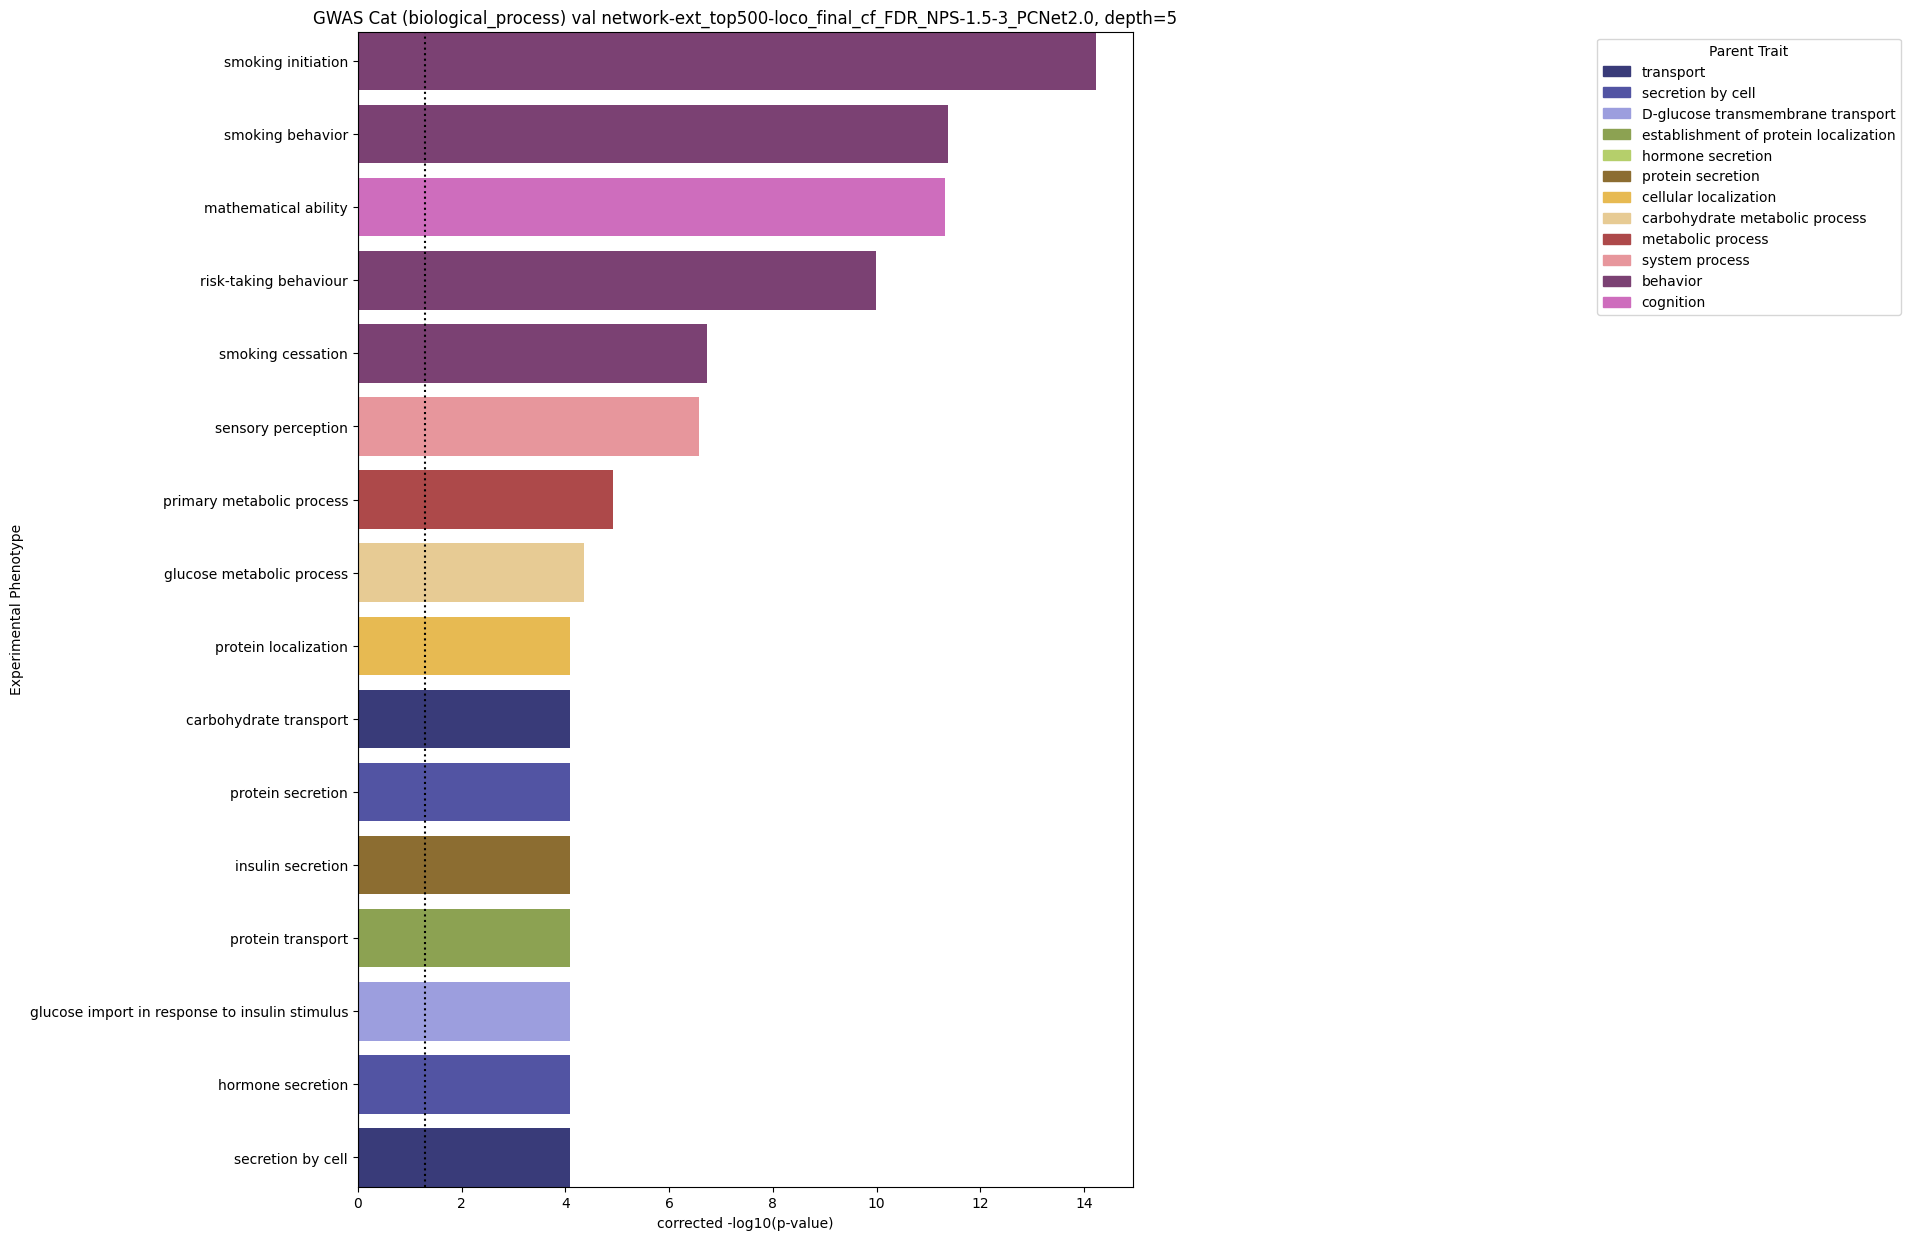

<Figure size 640x480 with 0 Axes>

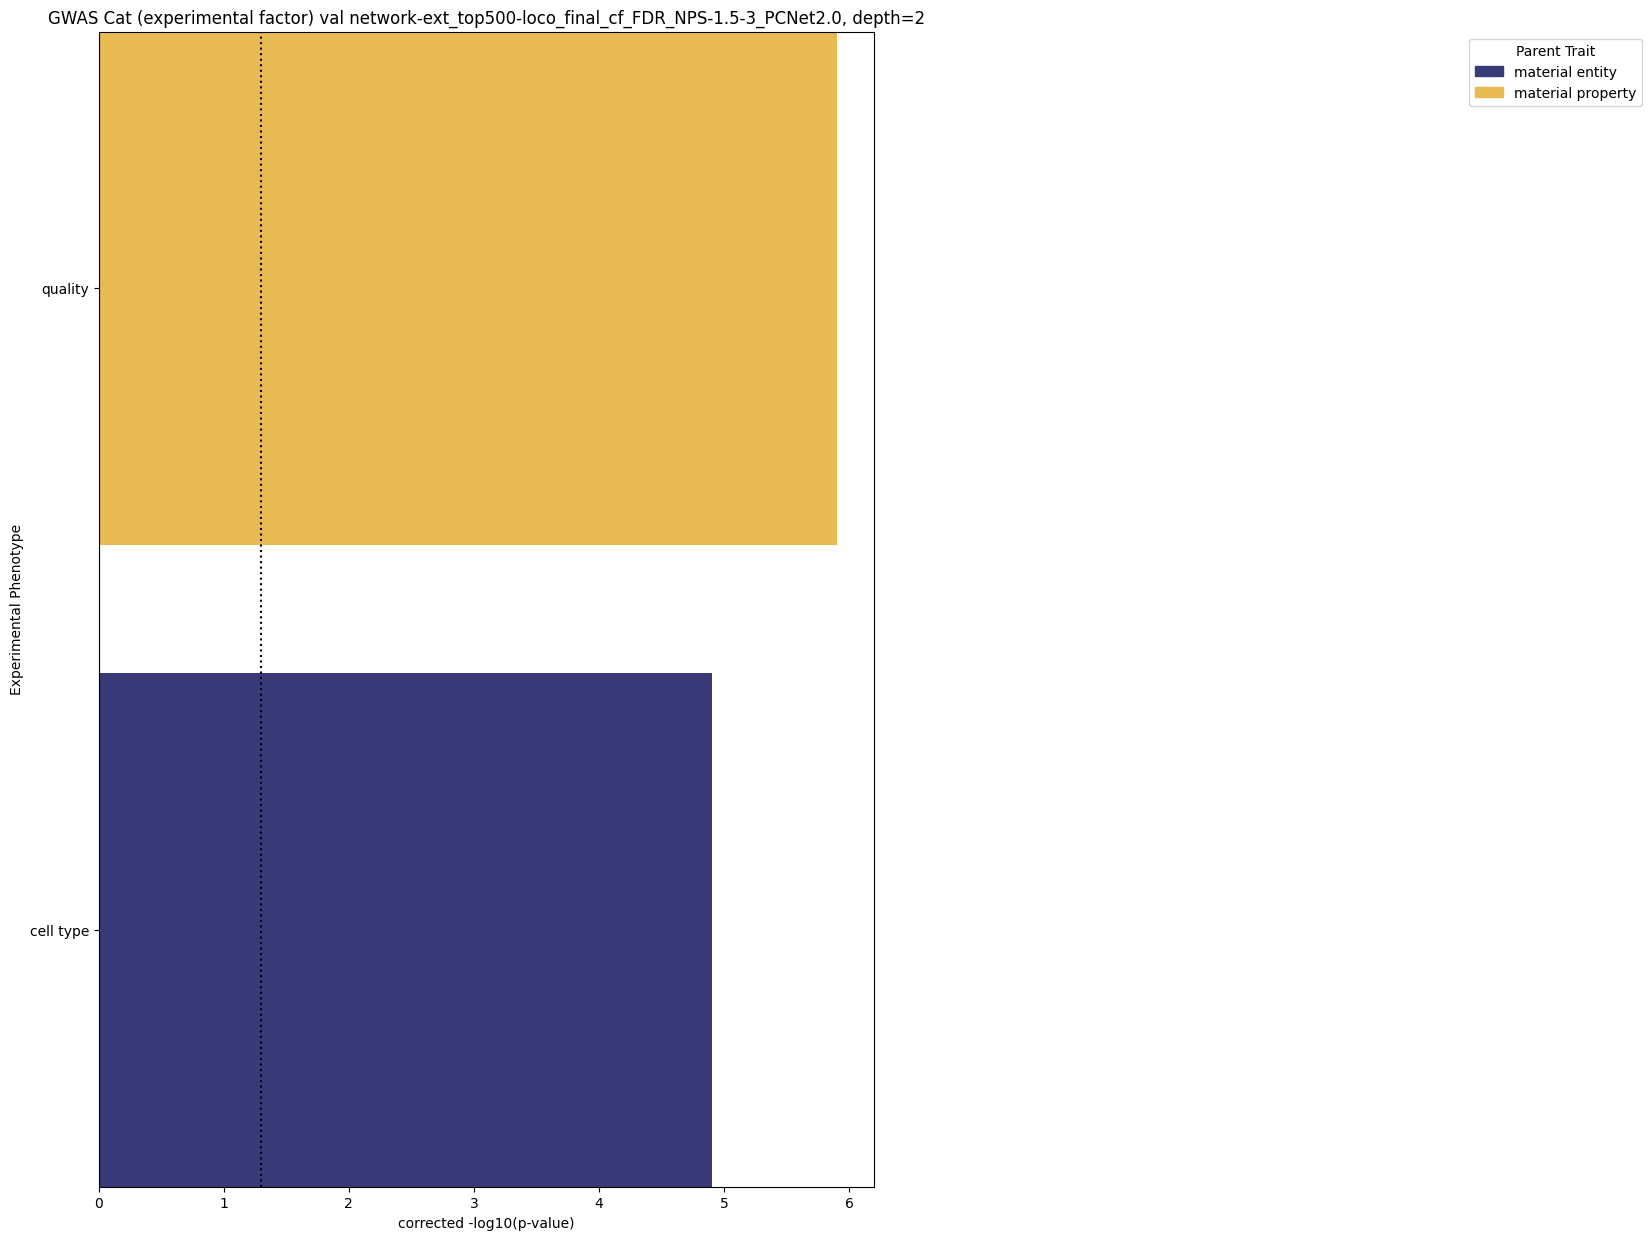

<Figure size 640x480 with 0 Axes>

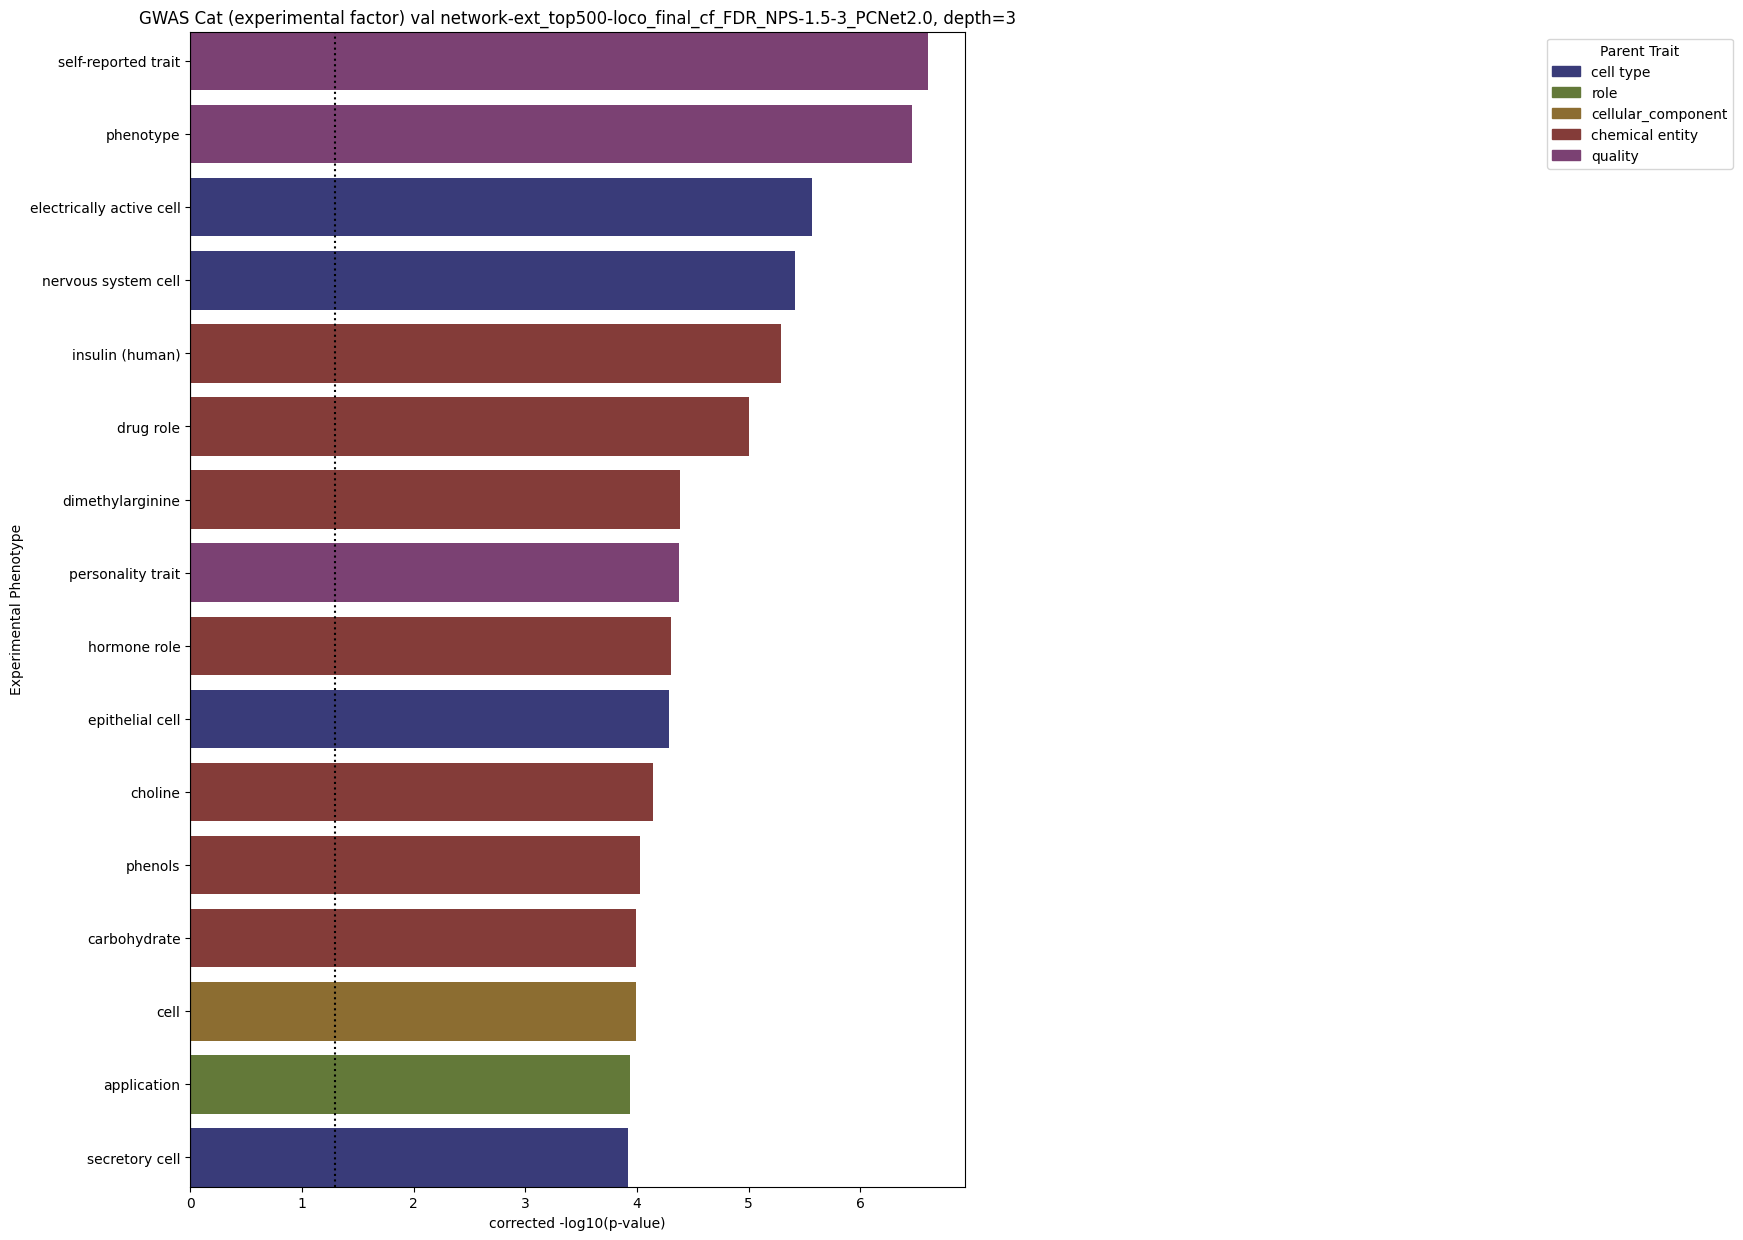

<Figure size 640x480 with 0 Axes>

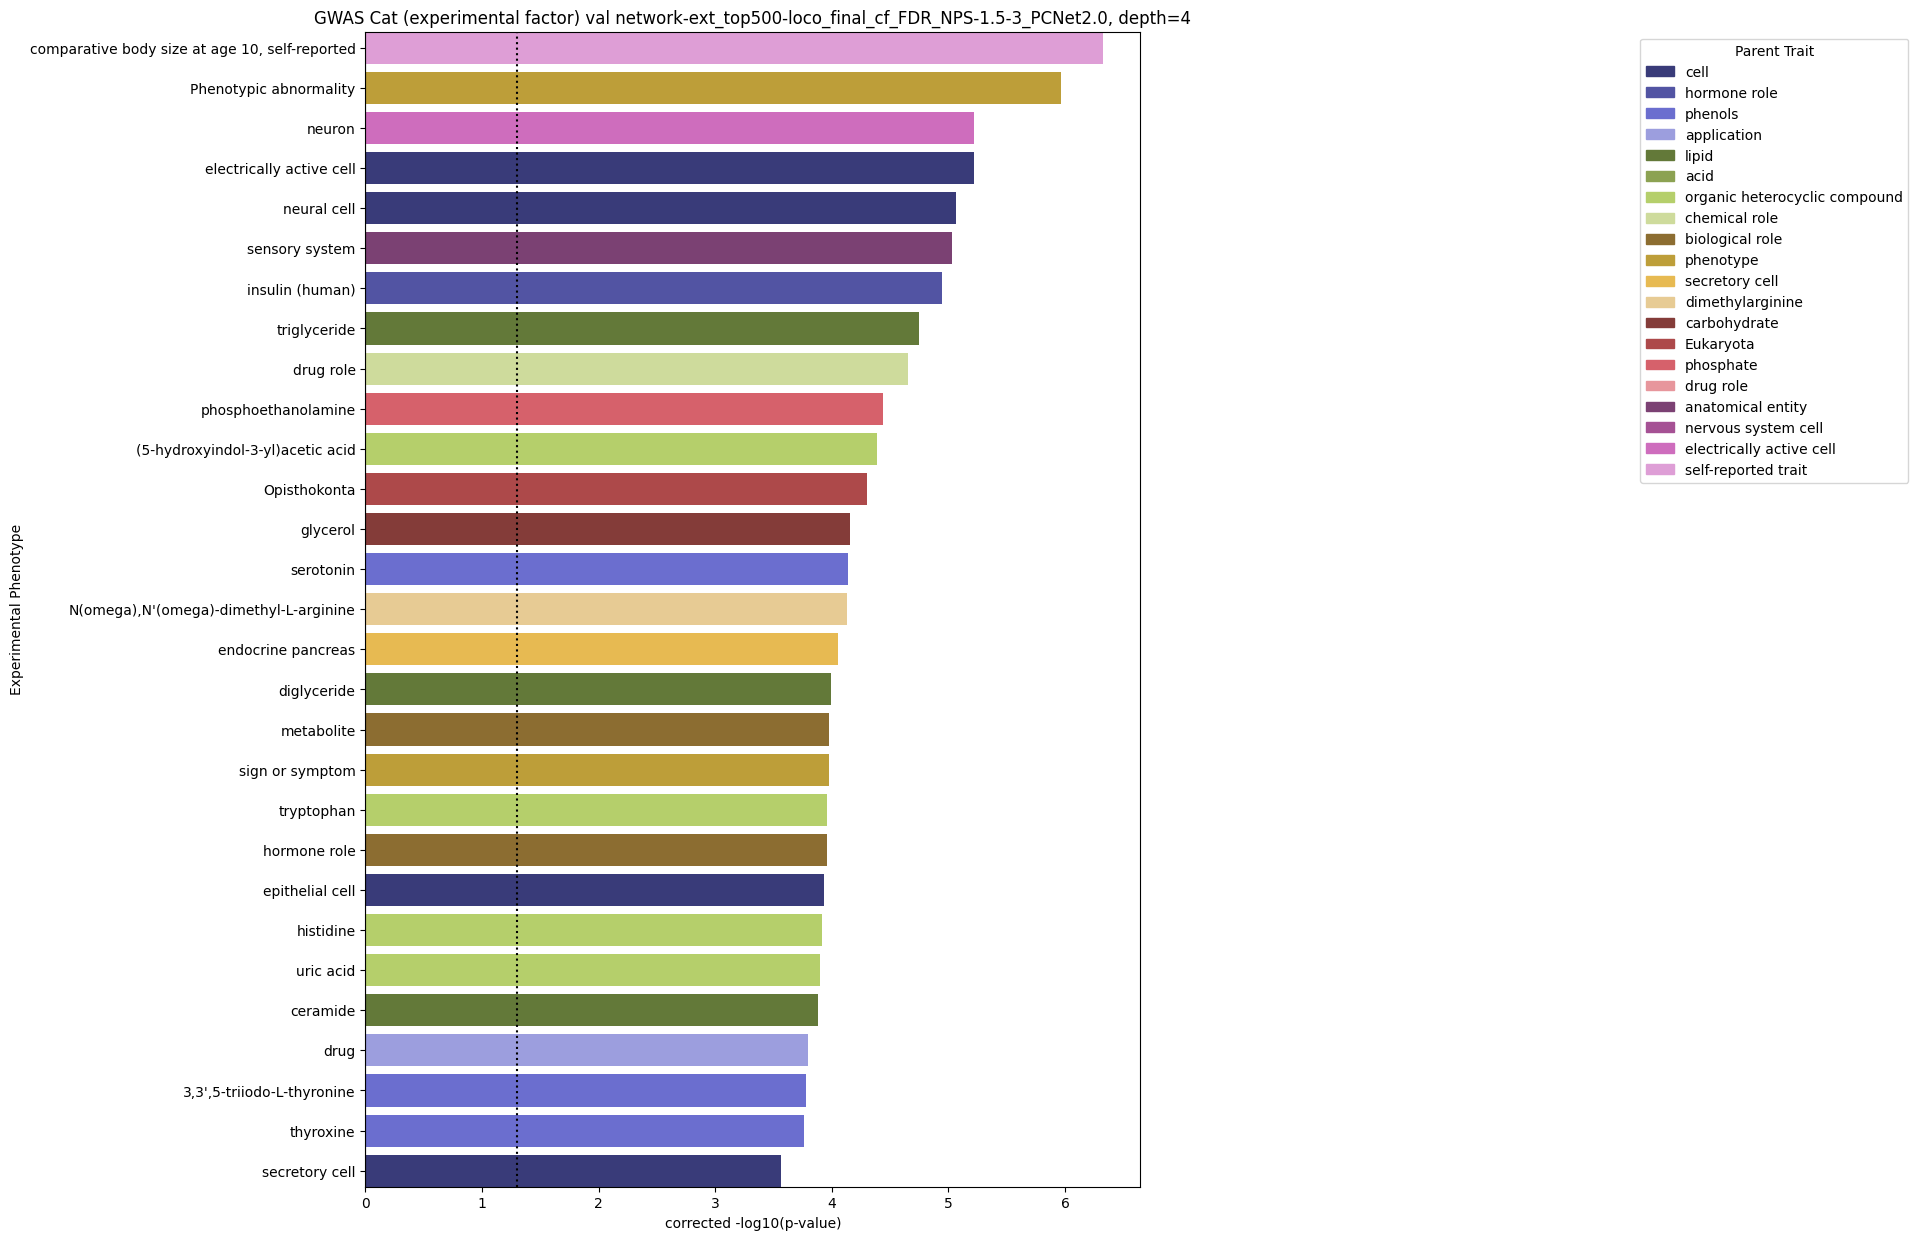

<Figure size 640x480 with 0 Axes>

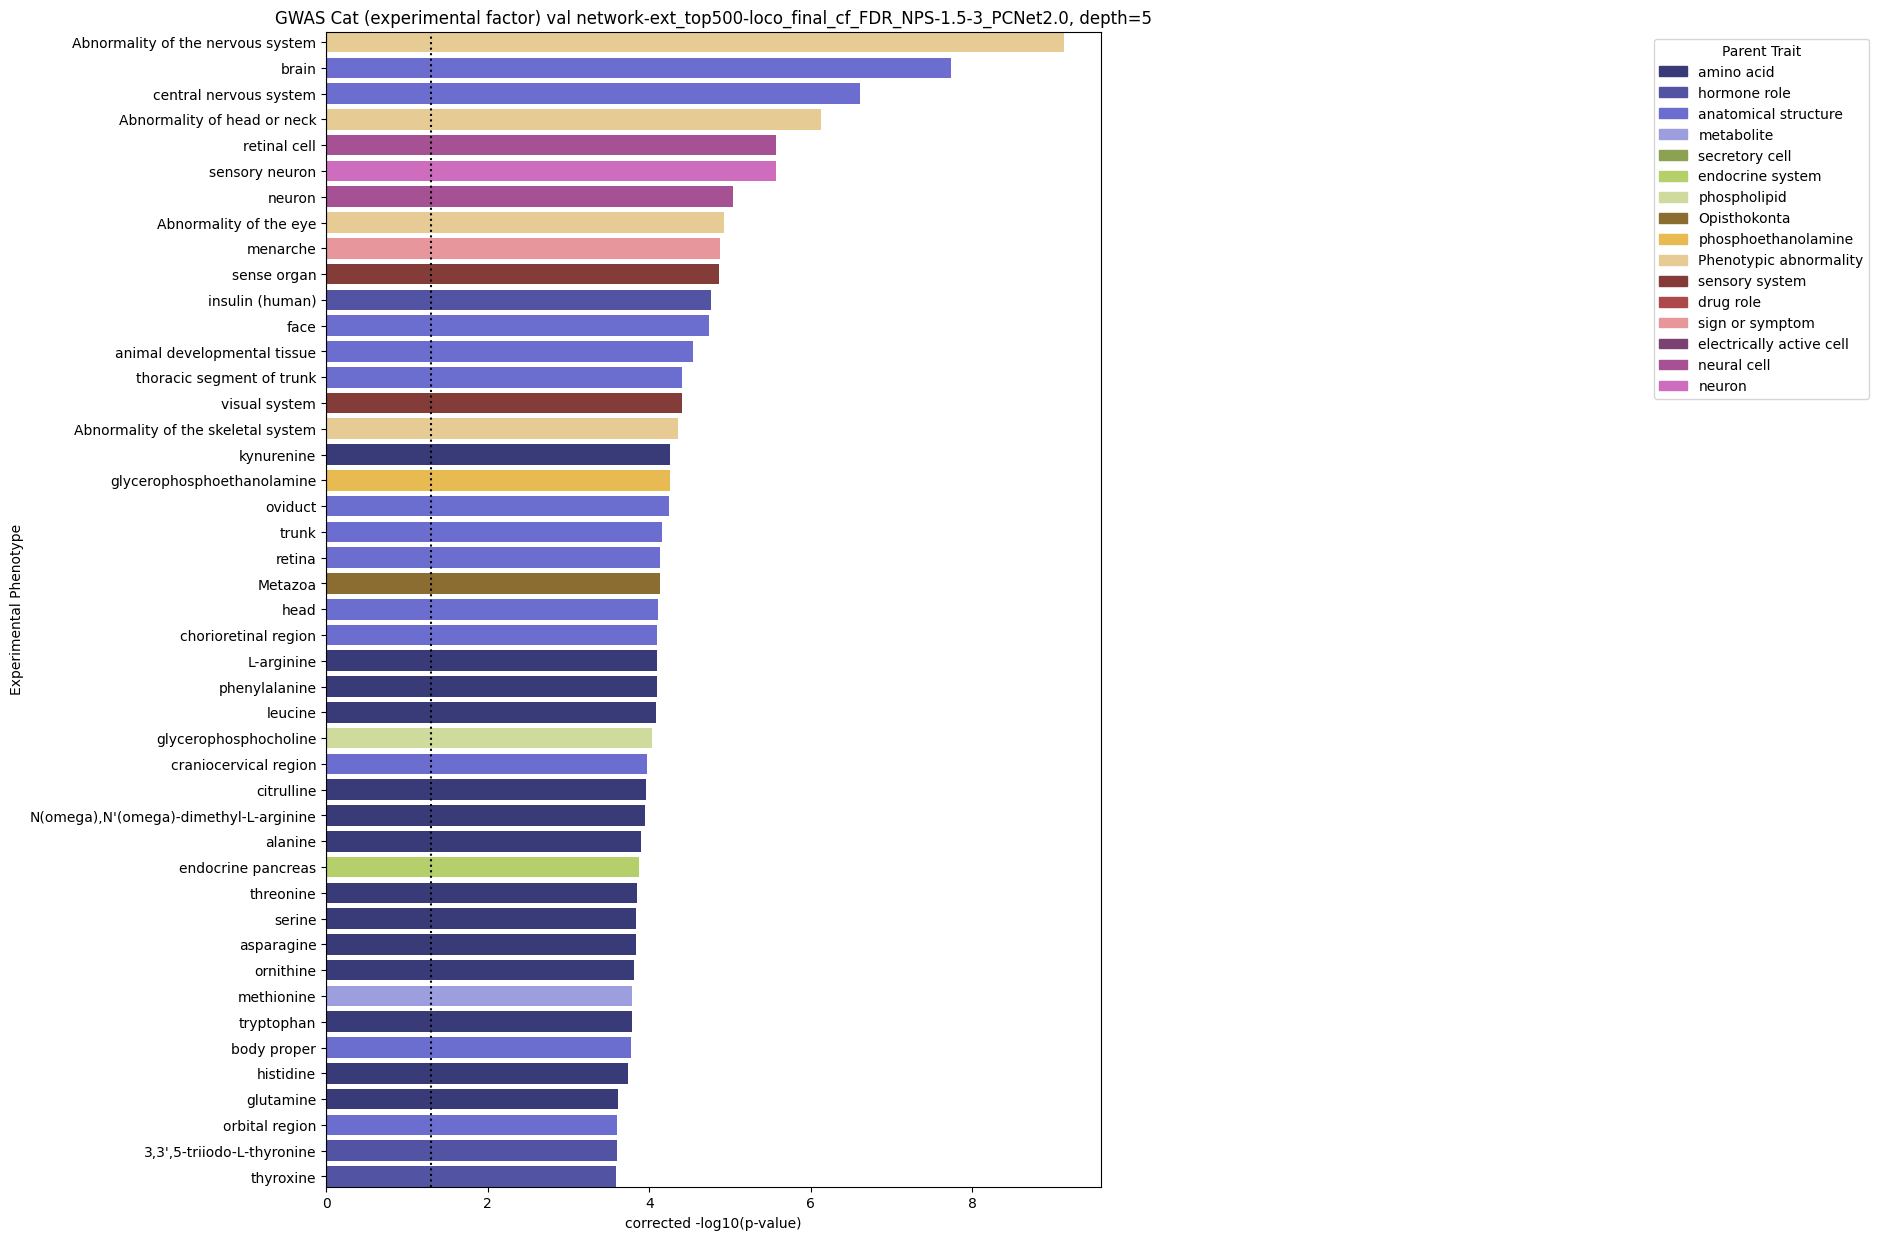

<Figure size 640x480 with 0 Axes>

In [79]:
for p in par:
    children=return_descendents_name(graph,id_to_name, name_to_id[p])
    #make the terms somewhat mutually exclusive- otherwise this is unintelligible
    if p=='disease':
        meas_child=return_descendents_name(graph,id_to_name, name_to_id['measurement'])
        children=set(children).difference(meas_child)
    if p=='biological_process':
        meas_child=return_descendents_name(graph,id_to_name, name_to_id['measurement'])
        disease_child=return_descendents_name(graph,id_to_name, name_to_id['disease'])
        children=set(children).difference(meas_child+disease_child)
    if p=='experimental factor':
        meas_child=return_descendents_name(graph,id_to_name, name_to_id['measurement'])
        disease_child=return_descendents_name(graph,id_to_name, name_to_id['disease'])
        bp_child=return_descendents_name(graph,id_to_name, name_to_id['biological_process'])
        children=set(children).difference(meas_child+disease_child+bp_child)
    tb=tbl[tbl.trait.isin(children)]
    depth_set=set(tb['depth'])
    for d in set(tb['depth']):
        t=tb[tb.depth==d]
        t=t[t['p_intersect']<0.05/len(tbl)]
        if len(t)>0:
            t=t.sort_values('p_intersect',ascending=False)
            # Assign a unique color for each parent_trait based on its index
            unique_traits = t.parent_trait.unique()
            color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}
            
            # Plotting
            fig = plt.figure(figsize=(10, 15))
            colors = [color_mapping[trait] for trait in t.parent_trait]  # Color assignment based on parent_trait
            
            plt.barh(y=t.trait, width=-np.log10(t.p_intersect*len(t)),label=t.parent_trait, color=colors)
            
            plt.ylabel('Experimental Phenotype')
            plt.xlabel('corrected -log10(p-value)')
            plt.axvline(-np.log10(0.05), color='black', ls=':')
            plt.axvline(0, color='black', ls='-')
        
            #plt.xticks(rotation=90)
            #plt.title(d)
            plt.title(f'GWAS Cat ({p}) val {val_lab_dict[sub_community]}, depth={d}')
            # Create legend patches (only one for each unique parent_trait)
            legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]
            
            # Add legend to the plot
            plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(2, 1))
            #plt.tight_layout()
            plt.margins(y=0)
            # Show the plot
            if save_fig:
                if not filter_traits:
                    plt.savefig((f'{outpath_dir}/GWAS_Cat_{p}_val_bar_depth-{d}.svg'), bbox_inches = "tight")
                else:
                    plt.savefig((f'{outpath_dir}/GWAS_Cat_{p}_val_filtered_bar_depth-{d}.svg'), bbox_inches = "tight")

            plt.show()
            
            # Clear the figure after showing
            plt.clf()